## ISI Epilepsy Brno & Montreal Dataframes with H2o AutoML 

<u>**Goal:**</u> Predict "onset_channel" using H2o AutoML on "outcome=11" & "segm_type=4" for all remaining patients, use "leave one patient out" approach and summarize the results.

24/11/2022

---

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# Import dataset

df = pd.read_csv('/home/marek/Desktop/Marek/2_PhD/ISI/Work/data/new_isi_data.csv')
# Remove unnamed column: ,index_col=0
df.head()

,Unnamed: 0,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [3]:
# Drop index column

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,power_4.0-8.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,0.781969,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,0.780688,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,0.740345,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,0.721173,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,0.937518,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [4]:
# Dataframe shape & number of null values 

print(df.shape)
print(df.isna().sum().sum())

(92464, 67)
33537


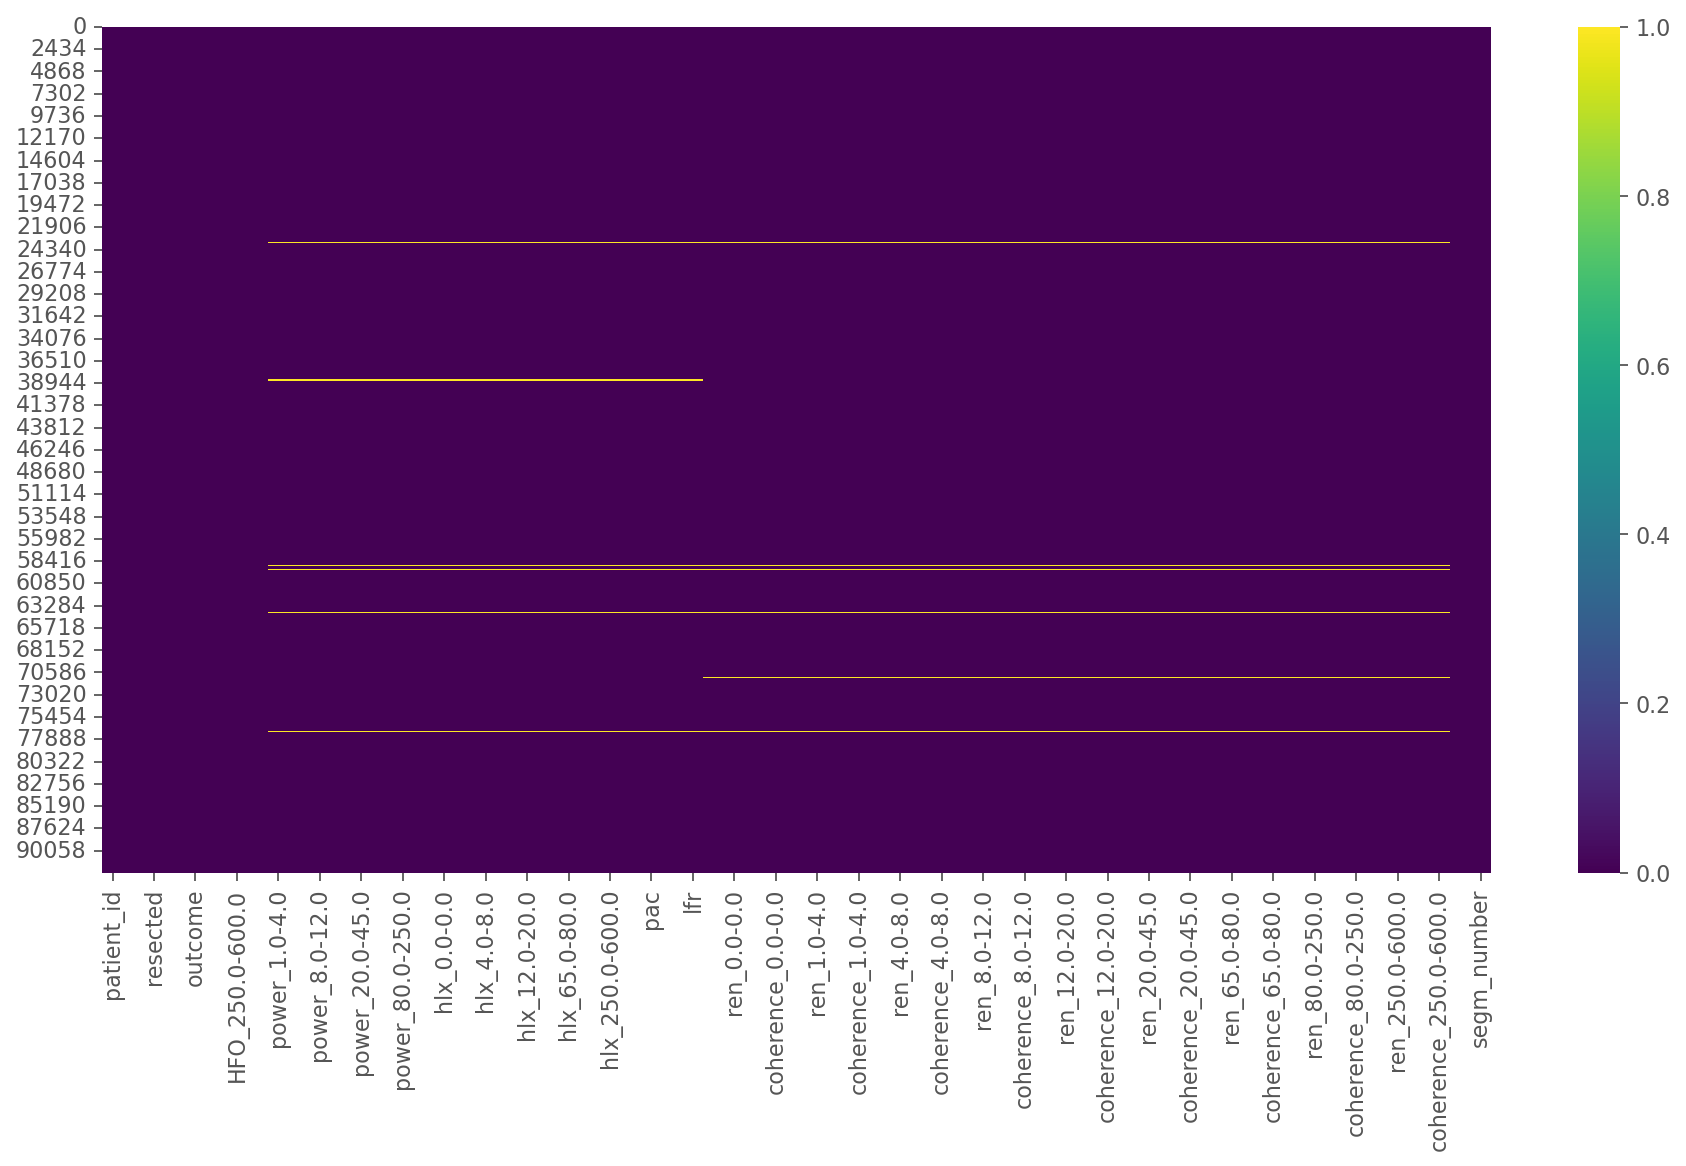

In [5]:
# Show null in columns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['figure.dpi'] = 160
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True);

#pd.options.display.min_rows = 15
#df.isnull().sum()

In [6]:
# Drop "nan" channels across all segments

df_nans = df[df.isnull().any(axis=1)]
for pts in df_nans.patient_id.unique():
    for chns in list(df_nans.loc[df_nans.patient_id == pts,'channel_name'].unique()):
        df = df.drop(df[(df.patient_id == pts) & (df.channel_name == chns)].index)

In [7]:
# Dataframe shape & number of null values 

print(df.shape)
print(df.isna().sum().sum())

(87648, 67)
0


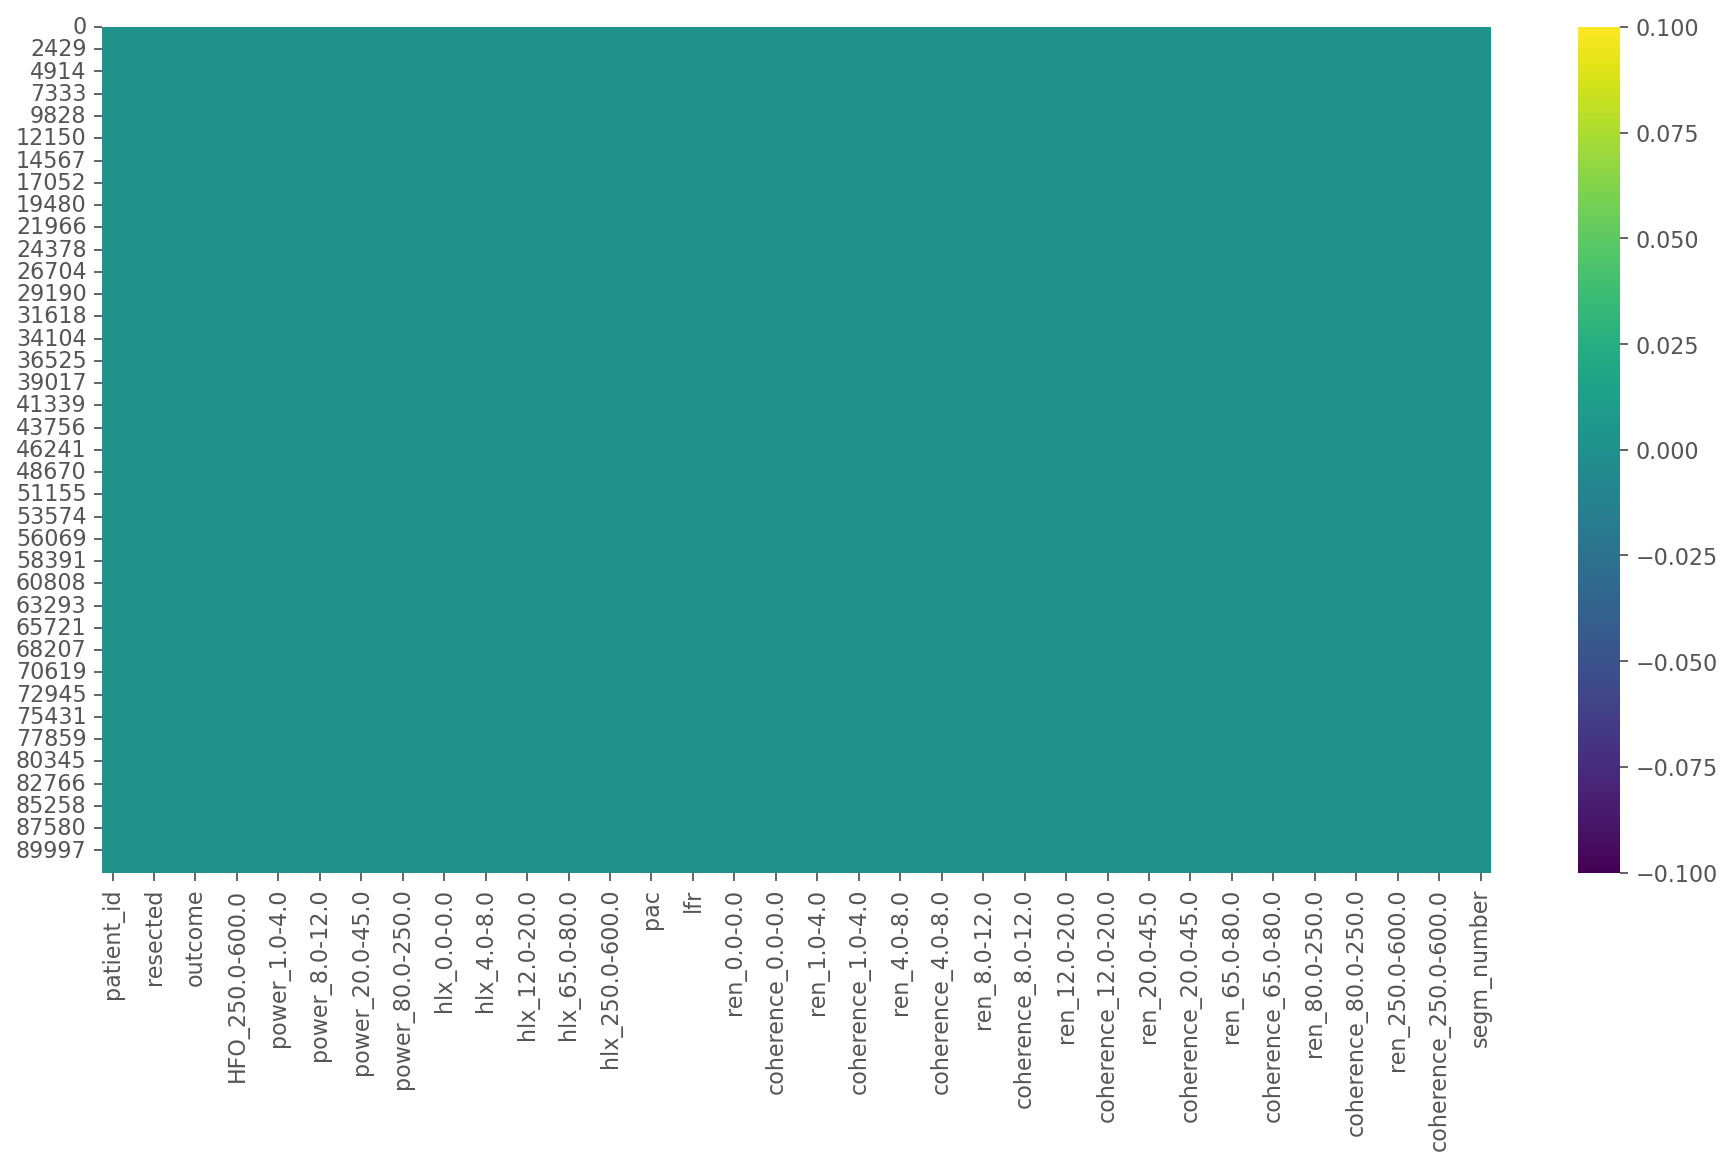

In [8]:
# Show null in columns

sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True);

In [9]:
# Dataframe preparation, target column 

outcome_11 = 11

df = df[df.outcome <= outcome_11]
mask = df.onset_channel == 'NON_SOZ'
df.loc[mask, 'onset_channel'] = 0
mask = df.onset_channel == 'SOZ'
df.loc[mask, 'onset_channel'] = 1
tmp = df['resected'].values * df['onset_channel'].values
df['target'] = tmp.astype(int)
df = df.rename(columns={'spike_rate':'spike_rate_0.0-0.0',
                        'pse':'pse_0.0-0.0',
                        'pac':'pac_0.0-0.0',
                        'fac':'fac_0.0-0.0',
                        'lfr':'lfr_0.0-0.0'})

features = [x for x in df if any(c.isdigit() for c in x)]
features.sort()

In [10]:
# Dataframe shape & visual

print(df.shape)
df.head()

(31344, 68)


,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,...,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target
0,583,ra1,0,0,11.0,11,34,22,0.533375,0.781969,...,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0,0
1,583,ra2,0,0,11.0,16,40,49,0.518898,0.780688,...,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0,0
2,583,ra3,0,0,11.0,20,35,61,0.466505,0.740345,...,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0,0
3,583,ra4,0,0,11.0,27,37,66,0.444008,0.721173,...,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0,0
4,583,ra5,0,0,11.0,11,58,63,0.588096,0.937518,...,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0,0


In [11]:
# Drop no target pts

target = 'target'
for pts in df.patient_id.unique():
    if sum(df.loc[df.patient_id == pts,target]) == 0:
        #print('patient',str(pts),'does not have target - droping this patient')
        df = df[df.patient_id != pts]

In [12]:
# Keep only segm_type = 4 

df = df.loc[df['segm_type'] == 4]
print(df.shape)
df.head()

(1959, 68)


,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,...,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target
34674,583,ra1,0,0,11.0,19,56,50,0.526201,0.474988,...,0.008171,0.962278,0.992315,0.951701,0.015386,0.894617,0.968141,4,0,0
34675,583,ra2,0,0,11.0,35,62,86,0.560877,0.560381,...,0.001929,0.989986,0.998410,0.982513,0.007849,0.952962,0.988048,4,0,0
34676,583,ra3,0,0,11.0,36,66,101,0.558763,0.576171,...,0.002038,0.989737,0.998386,0.982065,0.007308,0.951814,0.987657,4,0,0
34677,583,ra4,0,0,11.0,47,66,102,0.554024,0.565439,...,0.005044,0.975965,0.995656,0.975849,0.009962,0.941062,0.984107,4,0,0
34678,583,ra5,0,0,11.0,32,75,96,0.649021,0.658895,...,0.009224,0.944790,0.987954,0.980963,0.007094,0.949647,0.986945,4,0,0


In [13]:
# Number of unique patients

print(len(df.patient_id.unique()))
df.patient_id.unique()

18


array([ 583,  657,  953,  965, 1002, 1021, 1041,  723, 1043,  717, 1630,
         61,   63,   71,   77,   82,   89,   93])

In [14]:
# Scale selected features with standard scaler (z-score)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder        
scaler = StandardScaler()
for pts in df.patient_id.unique(): 
    df.loc[df.patient_id == pts,features] = scaler.fit_transform(df.loc[df.patient_id == pts,features])

In [15]:
# Dataframe info

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 34674 to 40452
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   1959 non-null   int64  
 1   channel_name                 1959 non-null   object 
 2   resected                     1959 non-null   int64  
 3   onset_channel                1959 non-null   object 
 4   outcome                      1959 non-null   float64
 5   HFO_80.0-250.0               1959 non-null   float64
 6   HFO_250.0-600.0              1959 non-null   float64
 7   spike_rate_0.0-0.0           1959 non-null   float64
 8   power_1.0-4.0                1959 non-null   float64
 9   power_4.0-8.0                1959 non-null   float64
 10  power_8.0-12.0               1959 non-null   float64
 11  power_12.0-20.0              1959 non-null   float64
 12  power_20.0-45.0              1959 non-null   float64
 13  power_65.0-80

In [16]:
# Training dataframe

training_df = df.drop(df.columns[[0, 1, 2, 3, 4, 65, 66]], axis=1)
print(training_df.shape)
training_df.head()

(1959, 61)


,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,power_8.0-12.0,power_12.0-20.0,power_20.0-45.0,power_65.0-80.0,power_80.0-250.0,...,coherence_65.0-80.0,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,target
34674,-0.126168,-0.178540,0.327280,0.145711,-0.010430,0.148045,0.148167,0.169495,-0.095213,0.046957,...,0.446552,0.404117,-0.350240,0.436340,0.495264,-0.878920,0.283770,-1.058841,-0.896756,0
34675,0.654391,-0.017576,1.077127,0.315222,0.355593,0.589720,0.630388,0.623422,0.277581,0.417085,...,0.606581,0.570445,-0.512471,0.780839,0.751936,0.870621,-0.549174,0.895020,0.883778,0
34676,0.703176,0.089732,1.389563,0.304886,0.423274,0.695283,0.745886,0.719663,0.349536,0.465228,...,0.606158,0.570046,-0.509640,0.777738,0.750921,0.845181,-0.608966,0.856571,0.848803,0
34677,1.239810,0.089732,1.410392,0.281723,0.377272,0.640256,0.666614,0.629601,0.258748,0.356233,...,0.558322,0.494313,-0.431500,0.606516,0.635949,0.492205,-0.315626,0.496511,0.531261,0
34678,0.508036,0.331178,1.285418,0.746111,0.777852,0.948572,0.973955,0.885383,0.472476,0.527939,...,0.341221,0.278691,-0.322855,0.218903,0.311639,0.782617,-0.632618,0.784001,0.785046,0


In [111]:
# Testing dataframes

testing_df_61 = df.loc[df['patient_id'] == 61]
testing_df_63 = df.loc[df['patient_id'] == 63]
testing_df_71 = df.loc[df['patient_id'] == 71]
testing_df_77 = df.loc[df['patient_id'] == 77]
testing_df_82 = df.loc[df['patient_id'] == 82]
testing_df_89 = df.loc[df['patient_id'] == 89]
testing_df_93 = df.loc[df['patient_id'] == 93]
testing_df_583 = df.loc[df['patient_id'] == 583]
testing_df_657 = df.loc[df['patient_id'] == 657]
testing_df_717 = df.loc[df['patient_id'] == 717]
testing_df_723 = df.loc[df['patient_id'] == 723]
testing_df_953 = df.loc[df['patient_id'] == 953]
testing_df_965 = df.loc[df['patient_id'] == 965]
testing_df_1002 = df.loc[df['patient_id'] == 1002]
testing_df_1021 = df.loc[df['patient_id'] == 1021]
testing_df_1041 = df.loc[df['patient_id'] == 1041]
testing_df_1043 = df.loc[df['patient_id'] == 1043]
testing_df_1630 = df.loc[df['patient_id'] == 1630]

## BINARY PROBLEM, Pt 61
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [18]:
# Start H2o

import h2o 
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu222.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu222.04, mixed mode, sharing)
  Starting server from /home/marek/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8e0cp374
  JVM stdout: /tmp/tmp8e0cp374/h2o_marek_started_from_python.out
  JVM stderr: /tmp/tmp8e0cp374/h2o_marek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_marek_r76ts1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.744 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [19]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_61)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
# Train dataframe summary describe

train.describe()

Rows:1959
Cols:61

,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,power_8.0-12.0,power_12.0-20.0,power_20.0-45.0,power_65.0-80.0,power_80.0-250.0,power_250.0-600.0,hlx_0.0-0.0,hlx_1.0-4.0,hlx_4.0-8.0,hlx_8.0-12.0,hlx_12.0-20.0,hlx_20.0-45.0,hlx_65.0-80.0,hlx_80.0-250.0,hlx_250.0-600.0,pse_0.0-0.0,pac_0.0-0.0,fac_0.0-0.0,lfr_0.0-0.0,lin_corr_median_0.0-0.0,ren_0.0-0.0,phase_sync_0.0-0.0,coherence_0.0-0.0,lin_corr_median_1.0-4.0,ren_1.0-4.0,phase_sync_1.0-4.0,coherence_1.0-4.0,lin_corr_median_4.0-8.0,ren_4.0-8.0,phase_sync_4.0-8.0,coherence_4.0-8.0,lin_corr_median_8.0-12.0,ren_8.0-12.0,phase_sync_8.0-12.0,coherence_8.0-12.0,lin_corr_median_12.0-20.0,ren_12.0-20.0,phase_sync_12.0-20.0,coherence_12.0-20.0,lin_corr_median_20.0-45.0,ren_20.0-45.0,phase_sync_20.0-45.0,coherence_20.0-45.0,lin_corr_median_65.0-80.0,ren_65.0-80.0,phase_sync_65.0-80.0,coherence_65.0-80.0,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,target
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int
mins,-1.6013951579349386,-3.312136126802352,-1.3269054866219792,-2.2205043132513556,-1.9838204984786072,-1.9324975637152064,-1.9507834066493213,-1.8390023188984783,-1.7599794293848972,-1.8342887896328697,-1.876008867017312,-2.539687921542354,-4.6379423080555835,-5.414470759164971,-3.318656834761586,-4.8068480222632655,-6.2918226347884145,-6.029949959243699,-6.2385492525211745,-8.649165565295888,-3.3912895988128287,-4.920190853603127,-5.789269230677893,-1.5811974069843409,-5.50971167680955,-1.9629349176512707,-8.60070932675851,-8.603994690935203,-6.9608398896811705,-3.156267702224169,-3.857684032914424,-3.944254866170328,-7.417704990956962,-3.030047315577566,-6.0217876193727315,-5.920974663496732,-7.6996464584758355,-2.5274437587346417,-6.376616343610124,-6.433330855135585,-7.894602834411457,-2.419362758270466,-6.395294263481418,-6.667290174836967,-7.660212844523255,-3.06132379248734,-6.432881511015735,-6.769099528197301,-8.111230601079427,-4.076020919855886,-6.472953964438009,-6.8745811193331425,-7.420171153186582,-2.3774639275950396,-6.822976434449434,-7.026761658497441,-6.166214335152441,-1.4470546855740165,-4.481533542246392,-8.323519740776677,0.0
mean,1.7618285302889447e-17,3.436920886779049e-17,-2.303929616531697e-18,5.644627560502657e-17,-6.009190541000908e-17,-4.6349642873755315e-17,-1.1302807648161384e-17,-3.649695563129329e-17,1.5571853702323057e-17,-1.9312351197398048e-17,-1.1858461261560205e-17,6.451002926288751e-17,-1.7840275697705854e-15,-1.5403910785805053e-14,3.724223620465983e-14,2.6594015618136568e-14,2.6727643535895407e-14,-2.7666410828963706e-13,3.8839862315925844e-14,4.320784181832682e-14,-1.2332799712022613e-18,-1.7753810574450135e-18,-2.2497195079074217e-18,-5.1906179007743525e-18,-7.96346495690603e-17,-4.33138767907959e-17,9.0446855734172e-16,2.0272547746405523e-15,-2.0111950299606107e-17,-2.2659825404947043e-17,1.1796119636642288e-16,-6.830473686658678e-16,2.0179712935386451e-16,8.304988641238964e-17,-7.556889142223966e-17,-1.190887666258078e-15,-5.64327230778705e-17,2.927345865710862e-18,-2.334287277361291e-16,-1.654926196081874e-15,-2.2150250383878856e-16,-4.92227786308419e-17,1.5265566588595902e-16,2.4947491988891457e-15,3.2959746043559335e-16,1.1926223897340549e-17,-3.415236843329339e-17,7.621941272573096e-16,1.597029800071148e-16,-3.9607260613611084e-17,6.025995674674434e-16,1.1160777163565783e-15,2.1972441227591233e-15,1.8336569242161094e-17,-1.2866227180885481e-14,-1.901365349887829e-15,-7.518508385317979e-15,-2.905661822261152e-17,-1.1774435593192578e-15,2.930728576489017e-14,0.0694231750893313
maxs,6.49237846226698,11.944907774857237,8.127866889

In [21]:
# Test dataframe summary describe

test.describe()

Rows:150
Cols:68

,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,power_8.0-12.0,power_12.0-20.0,power_20.0-45.0,power_65.0-80.0,power_80.0-250.0,power_250.0-600.0,hlx_0.0-0.0,hlx_1.0-4.0,hlx_4.0-8.0,hlx_8.0-12.0,hlx_12.0-20.0,hlx_20.0-45.0,hlx_65.0-80.0,hlx_80.0-250.0,hlx_250.0-600.0,pse_0.0-0.0,pac_0.0-0.0,fac_0.0-0.0,lfr_0.0-0.0,lin_corr_median_0.0-0.0,ren_0.0-0.0,phase_sync_0.0-0.0,coherence_0.0-0.0,lin_corr_median_1.0-4.0,ren_1.0-4.0,phase_sync_1.0-4.0,coherence_1.0-4.0,lin_corr_median_4.0-8.0,ren_4.0-8.0,phase_sync_4.0-8.0,coherence_4.0-8.0,lin_corr_median_8.0-12.0,ren_8.0-12.0,phase_sync_8.0-12.0,coherence_8.0-12.0,lin_corr_median_12.0-20.0,ren_12.0-20.0,phase_sync_12.0-20.0,coherence_12.0-20.0,lin_corr_median_20.0-45.0,ren_20.0-45.0,phase_sync_20.0-45.0,coherence_20.0-45.0,lin_corr_median_65.0-80.0,ren_65.0-80.0,phase_sync_65.0-80.0,coherence_65.0-80.0,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target
type,int,string,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int
mins,61.0,NaN,0.0,0.0,11.0,-1.5614508713353812,-1.389344715949922,-1.2700098874291814,-0.18418507228387332,-0.15762312923712915,-0.15311520474542345,-0.14666434915908438,-0.11833998359362596,-0.14327099276371064,-0.1531127871158415,-0.1478542601225837,-1.602239563703076,-2.8515938528410203,-2.4643694464091226,-3.318656834761586,-3.0348940810862253,-3.3064306802709207,-2.8198361419317934,-3.356858358125383,-8.649165565295888,-0.1488116736813609,-3.8620833375765655,-2.3703614904718666,-1.2252913466088338,-3.760091581767422,-1.4755944623035258,-8.44142037503064,-8.463660741075376,-3.7311691080495457,-1.9415968298755224,-2.193571721424229,-2.5809321354967896,-3.693348421657242,-1.946014320029525,-2.4367516548337473,-2.7647179514174978,-4.506767528693354,-1.9651246304025611,-2.5722058830308816,-2.56950056722493,-4.595007872371264,-2.14773978556358,-2.8560705177576233,-2.746049116251004,-4.059847348404458,-2.1607049287749183,-2.637931244748594,-2.586845569485131,-3.497658493744475,-1.918426153746316,-2.0540161481190053,-1.967756800662616,-3.4388035806827313,-1.5466681577528498,-2.3584612051444287,-5.974075474215989,-6.166214335152441,-1.1650234441406062,-3.518228129730636,-8.323519740776677,4.0,0.0,0.0
mean,61.0,NaN,0.14666666666666667,0.06,11.0,-7.003946034256359e-17,1.491862189340054e-16,-1.5612511283791264e-17,-1.951563910473908e-18,-2.0816681711721685e-17,-1.734723475976807e-18,5.204170427930421e-17,1.951563910473908e-17,2.677979366039196e-17,1.8214596497756474e-17,-2.3852447794681098e-18,1.2836953722228372e-16,3.8632291810003494e-15,-7.049395789326951e-14,-1.4025065830924888e-13,-1.4422490979271174e-14,5.3870970184721756e-14,1.1594056877756165e-13,2.0067281170099704e-14,-2.0838365755171395e-14,-7.37257477290143e-18,9.107298248878237e-17,1.9081958235744878e-17,5.182486384480711e-17,2.3765711620882257e-16,2.1684043449710089e-16,-1.068155980332719e-15,4.444795226321574e-15,-3.2439329000766293e-16,-3.625572064791527e-16,-2.6107588313450947e-16,-7.988401606873197e-16,-2.654126918244515e-16,-1.0408340855860843e-17,-3.8337388819087437e-16,-1.119764003743029e-15,-6.071532165918825e-18,-7.450637329320386e-16,-3.365363543395006e-16,1.704365815147213e-15,-3.5648567431323386e-16,3.469446951953614e-17,-7.806255641895632e-16,2.4216739724636227e-15,4.7704895589362195e-17,2.463307335887066e-16,-3.625572064791527e-16,4.85722573273506e-16,-5.377642775528102e-17,-1.474514954580286e-16,-5.30825383648903e-16,5.048045315092509e-16,-1.4137996329210978e-16,6.852157730108388e-16,-2.992397996059992

In [22]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [23]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [24]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [25]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.84 s, sys: 298 ms, total: 4.14 s
Wall time: 9min 55s


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_6_AutoML_1_20221123_153214

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.001672878609138766
RMSE: 0.04090083873392777
LogLoss: 0.02280279033580328
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1954
Null deviance: 987.9014381081303
Residual deviance: 89.34133253567725
AIC: 99.34133253567725

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8693054759152352
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.869305     1         97
max f2                       0.869305     1         97
max f0point5                 0.869305     1         97
max accuracy                 0.869305     1         97
max precision                0.996476     1         0
max recall                   0.869305     1         97
max specificity              0.996476     1         0
max absolute_mcc             0.869305     1         97
max min_per_class_accuracy   0.869305     1         97
max mean_per_class_accuracy  0.869305     1         97
max tns                      0.996476     1823      0
max fns                      0.996476     134       0
max fps                      0.00101085   1823      399
max tps                      0.869305     136       97
max tnr                      0.996476     1         0
max fnr                      0.996476     0.985294  0
max fpr                      0.00101085   1         399
max tpr                      0.869305     1         97

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.26 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.983358           14.4044  14.4044            1                0.989515    1                           0.989515            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.96019            14.4044  14.4044            1                0.970858    1                           0.980187            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.940505           14.4044  14.4044            1                0.94961     1                           0.97034             0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.927216           14.4044  14.4044            1                0.933022    1                           0.960892            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.911408           14.4044  14.4044            1                0.92112     1                           0.953181            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.114126           5.58538  9.9949             0.387755         0.438903    0.693878                    0.696042            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.064156

In [26]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_6_AutoML_1_20221123_153214,0.917916,0.151508,0.560286,0.210154,0.20772,0.0431476
StackedEnsemble_BestOfFamily_4_AutoML_1_20221123_153214,0.917887,0.152082,0.54899,0.192483,0.208597,0.0435125
StackedEnsemble_Best1000_1_AutoML_1_20221123_153214,0.917454,0.150971,0.574595,0.225793,0.207618,0.043105
XGBoost_lr_search_selection_AutoML_1_20221123_153214_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_AllModels_6_AutoML_1_20221123_153214,0.916286,0.149228,0.582073,0.179972,0.205673,0.0423014
StackedEnsemble_AllModels_3_AutoML_1_20221123_153214,0.915298,0.14942,0.586387,0.213393,0.20562,0.0422798
StackedEnsemble_AllModels_4_AutoML_1_20221123_153214,0.913556,0.152517,0.569043,0.249994,0.20783,0.0431934
XGBoost_grid_1_AutoML_1_20221123_153214_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_5_AutoML_1_20221123_153214,0.907062,0.16322,0.558456,0.219427,0.212512,0.0451614
StackedEnsemble_AllModels_2_AutoML_1_20221123_153214,0.907033,0.155892,0.566822,0.243079,0.208869,0.0436264


In [27]:
# Explain a single H2O model (e.g. leader model from AutoML)

#exm = aml.leader.explain(test)

In [30]:
# One of the leaders model 

model = h2o.get_model('XGBoost_lr_search_selection_AutoML_1_20221123_153214_select_grid_model_2')

In [31]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.0002542930980763695
RMSE: 0.01594657010383015
LogLoss: 0.008134309449455993
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9868367910385132
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      141  0    0        (0.0/141.0)
1      0    9    0        (0.0/9.0)
Total  141  9    0        (0.0/150.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.986837     1         8
max f2                       0.986837     1         8
max f0point5                 0.986837     1         8
max accuracy                 0.986837     1         8
max precision                0.99391      1         0
max recall                   0.986837     1         8
max specificity              0.99391      1         0
max absolute_mcc             0.986837     1         8
max min_per_class_accuracy   0.986837     1         8
max mean_per_class_accuracy  0.986837     1         8
max tns                      0.99391      141       0
max fns                      0.99391      8         0
max fps                      0.000329444  141       149
max tps                      0.986837     9         8
max tnr                      0.99391      1         0
max fnr                      0.99391      0.888889  0
max fpr                      0.000329444  1         149
max tpr                      0.986837     1         8

Gains/Lift Table: Avg response rate:  6.00 %, avg score:  6.67 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0133333                   0.990858           16.6667  16.6667            1                0.992913     1                           0.992913            0.222222        0.222222                   1566.67  1566.67            0.222222
2        0.02                        0.989537           16.6667  16.6667            1                0.989756     1                           0.991861            0.111111        0.333333                   1566.67  1566.67            0.333333
3        0.0333333                   0.98853            16.6667  16.6667            1                0.98934      1                           0.990852            0.222222        0.555556                   1566.67  1566.67            0.555556
4        0.04                        0.987581           16.6667  16.6667            1                0.987833     1                           0.990349            0.111111        0.666667                   1566.67  1566.67            0.666667
5        0.0533333                   0.987129           16.6667  16.6667            1                0.987469     1                           0.989629            0.222222        0.888889                   1566.67  1566.67            0.888889
6        0.1                         0.038418           2.38095  10                 0.142857         0.194795     0.6                         0.618707            0.111111        1                          138.095  900                0.957447
7        0.153333                    0.0216851          0        6.52174            0                0.031425     0.391304                    0.414435            0               1                          -100     552.174            0.900709
8        0.2                         0.0141746          0        5                  0                0.0166857    0.3         

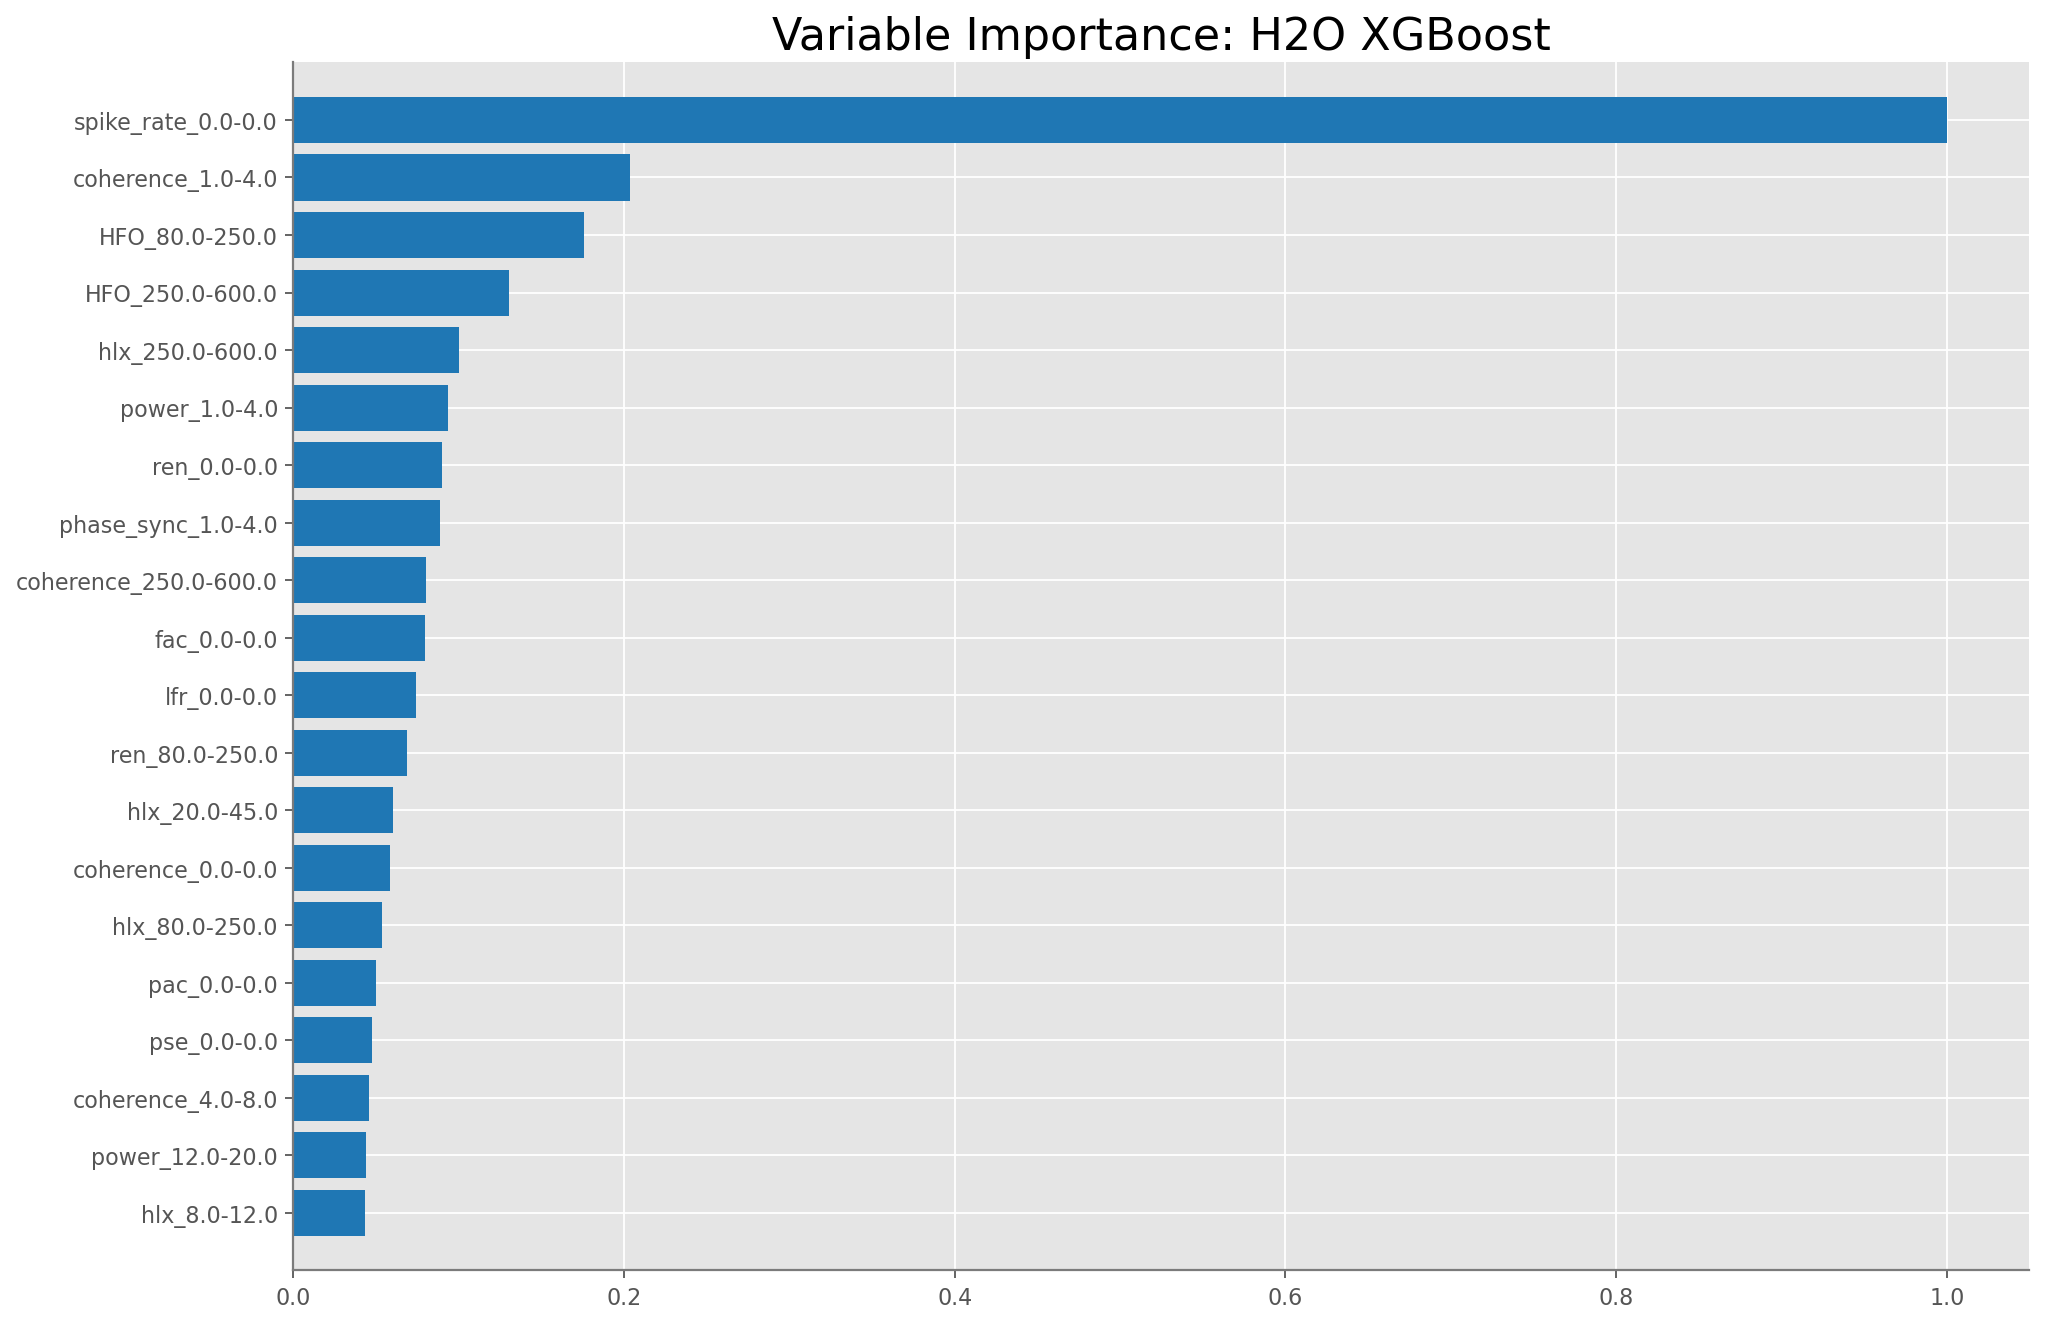

<Figure size 2240x1120 with 0 Axes>

In [32]:
# Show variable importance

model.varimp_plot(num_of_features=20)

In [33]:
# Show variable importance

model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,spike_rate_0.0-0.0,4055.516602,1.000000,0.304226
1,coherence_1.0-4.0,825.644714,0.203586,0.061936
2,HFO_80.0-250.0,713.215698,0.175863,0.053502
3,HFO_250.0-600.0,529.112793,0.130467,0.039692
4,hlx_250.0-600.0,405.596558,0.100011,0.030426
5,power_1.0-4.0,380.228149,0.093756,0.028523
6,ren_0.0-0.0,364.844116,0.089962,0.027369
7,phase_sync_1.0-4.0,359.367310,0.088612,0.026958
8,coherence_250.0-600.0,326.153931,0.080422,0.024467
9,fac_0.0-0.0,321.674225,0.079318,0.024130


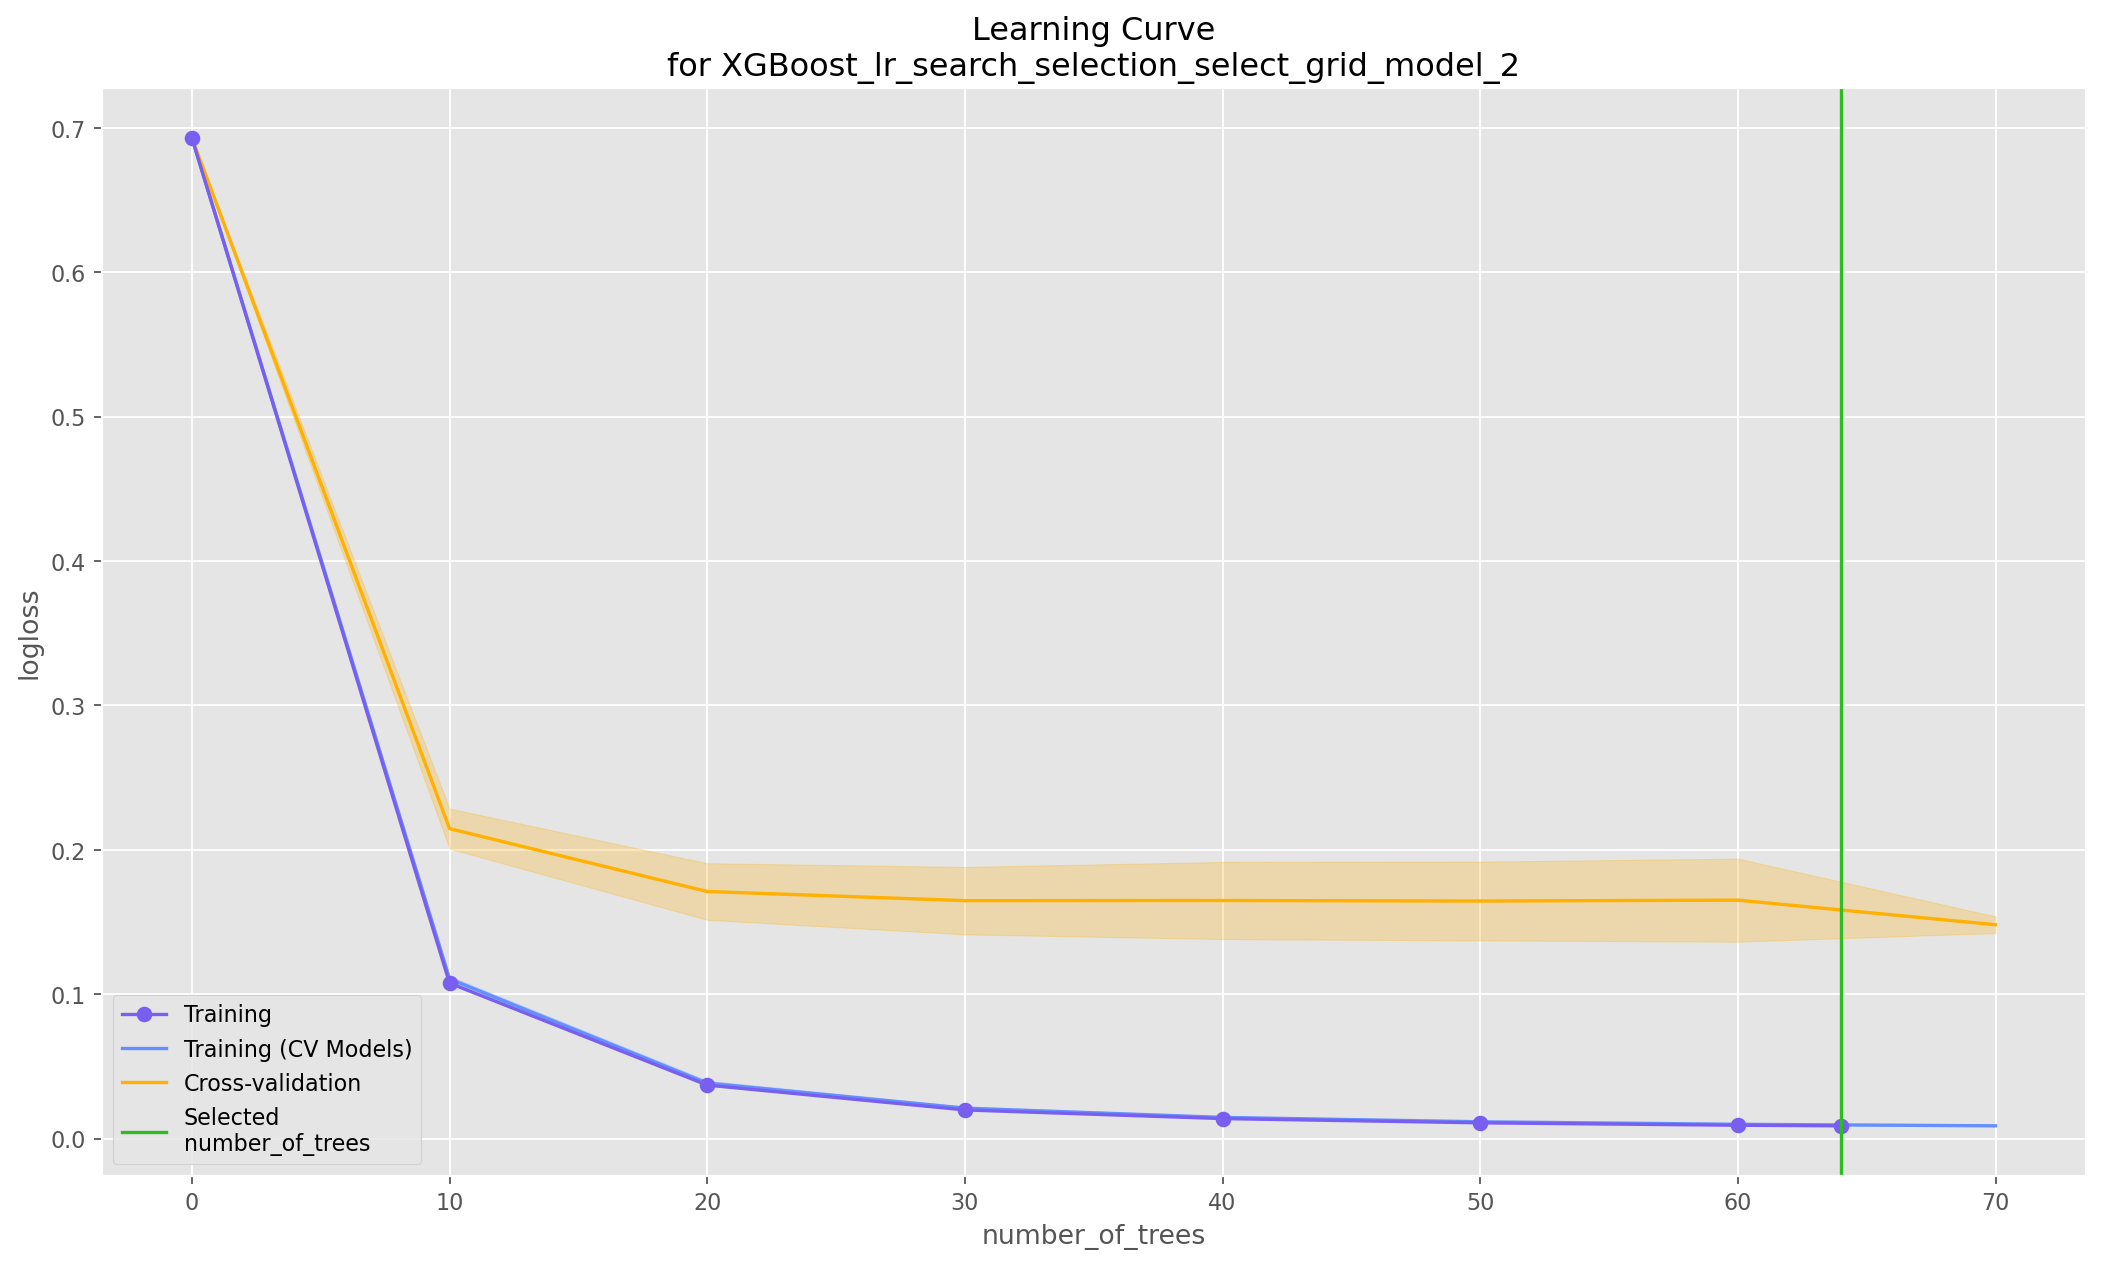

In [34]:
# Learning curve plot 

learning_curve_plot = model.learning_curve_plot()

In [35]:
# Make prediction

preds = aml.leader.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [36]:
# Combine the prediction with the test dataset

df = test.cbind(preds)

# Preview
df.head(10)

patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,power_8.0-12.0,power_12.0-20.0,power_20.0-45.0,power_65.0-80.0,power_80.0-250.0,power_250.0-600.0,hlx_0.0-0.0,hlx_1.0-4.0,hlx_4.0-8.0,hlx_8.0-12.0,hlx_12.0-20.0,hlx_20.0-45.0,hlx_65.0-80.0,hlx_80.0-250.0,hlx_250.0-600.0,pse_0.0-0.0,pac_0.0-0.0,fac_0.0-0.0,lfr_0.0-0.0,lin_corr_median_0.0-0.0,ren_0.0-0.0,phase_sync_0.0-0.0,coherence_0.0-0.0,lin_corr_median_1.0-4.0,ren_1.0-4.0,phase_sync_1.0-4.0,coherence_1.0-4.0,lin_corr_median_4.0-8.0,ren_4.0-8.0,phase_sync_4.0-8.0,coherence_4.0-8.0,lin_corr_median_8.0-12.0,ren_8.0-12.0,phase_sync_8.0-12.0,coherence_8.0-12.0,lin_corr_median_12.0-20.0,ren_12.0-20.0,phase_sync_12.0-20.0,coherence_12.0-20.0,lin_corr_median_20.0-45.0,ren_20.0-45.0,phase_sync_20.0-45.0,coherence_20.0-45.0,lin_corr_median_65.0-80.0,ren_65.0-80.0,phase_sync_65.0-80.0,coherence_65.0-80.0,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target,predict,p0,p1
61,a'1,0,0,11,1.56861,0.102283,3.73607,-0.13819,-0.127667,-0.135278,-0.136909,-0.111921,-0.125751,-0.136561,-0.136216,0.803968,-0.894297,0.959119,0.133908,1.52996,0.29342,1.06874,0.114623,0.904402,-0.122708,0.557157,1.66226,-0.793527,0.8067,-0.879867,0.162277,0.15823,0.83841,-1.5168,1.16135,1.16521,0.786961,-1.15397,1.00091,1.05639,0.726348,-0.953196,0.845557,0.913768,0.638075,-0.393711,0.686642,0.768903,0.440841,0.153018,0.161498,0.417426,-0.0118196,1.0176,-0.529753,-0.267415,-0.354737,0.754783,-0.684472,-0.35928,-0.0914979,0.829388,-0.177376,-0.0360786,4,0,0,0,0.991693,0.0083065
61,a'10,0,0,11,-0.667149,1.38082,-0.999411,-0.179119,-0.153581,-0.149936,-0.144706,-0.117622,-0.141969,-0.15127,-0.145264,-0.478371,1.16471,-0.936241,0.890354,-0.806142,0.919588,-1.65751,0.625049,0.454059,-0.144393,-0.164284,0.212338,-0.803854,0.632342,-0.707613,0.157562,0.152311,0.651697,-0.55649,0.680547,0.695999,0.681518,-0.860822,0.775694,0.801039,0.550374,-0.521453,0.54152,0.588963,0.539349,-0.653916,0.566255,0.630149,0.419528,-0.37532,0.371601,0.335499,0.394099,-0.277307,0.357077,0.28402,0.655991,-0.471905,0.680559,0.549604,0.205911,0.473278,0.171525,0.155701,4,0,0,0,0.997439,0.00256084
61,a'2,0,0,11,1.65804,-0.00426179,2.72132,-0.074505,-0.0843041,-0.109858,-0.122434,-0.101748,-0.0961186,-0.108247,-0.103526,0.219657,-0.91843,0.897057,0.0612759,1.404,0.244887,-2.75583,0.586636,0.317268,-0.0890388,-0.389391,1.40274,-0.808184,0.723889,-0.66709,0.147398,0.154376,0.759921,-0.938957,0.983094,1.0251,0.707424,-0.765169,0.84044,0.92544,0.61655,-0.420236,0.633262,0.651993,0.585416,-0.391642,0.580818,0.684268,0.548776,0.490478,0.467109,0.566779,0.201291,0.546184,-0.229578,-0.0246553,-0.220712,1.08398,-0.50909,-0.306287,0.304657,0.0973131,0.296028,0.0887779,4,0,0,0,0.994355,0.0056452
61,a'3,0,0,11,0.584873,0.208828,1.16538,-0.17307,-0.149698,-0.148405,-0.143837,-0.116602,-0.138108,-0.147291,-0.140403,-0.517682,-0.926572,1.33053,0.791538,1.5037,0.164548,-1.98387,0.471698,0.281415,-0.141252,-0.607472,0.731816,-0.794577,0.665945,-0.486178,0.16329,0.159358,0.722572,-0.647416,0.86786,0.924626,0.631762,-0.469476,0.756693,0.681713,0.466005,-0.210451,0.375818,0.39657,0.559737,-0.251847,0.55885,0.600889,0.564163,0.0644134,0.521332,0.614035,0.306523,0.281882,-0.0169133,0.183907,-0.137655,0.350504,-0.341564,-0.231685,-0.316448,-0.0439443,-0.507179,-0.0235617,4,0,0,0,0.992887,0.00711287
61,a'4,0,0,11,0.137722,0.635007,-0.187615,-0.183482,-0.157052,-0.152729,-0.146474,-0.118246,-0.14302,-0.152771,-0.147171,-0.827798,-0.765988,1.35204,0.137177,1.63798,0.560833,-1.82626,0.447908,-0.0167334,-0.148211,-1.03535,0.413557,-0.791214,0.665945,-0.486178,0.16329,0.159358,0.722572,-0.647416,0.86786,0.924626,0.631762,-0.469476,0.756693,0.681713,0.466005,-0.210451,0.375818,0.39657,0.559737,-0.251847,0.55885,0.600889,0.564163,0.0644134,0.521332,0.6

In [37]:
# Create dataframe for first 20 predictions

df = h2o.as_list(df)

preds = df[['onset_channel', 'predict']].tail(50)
preds

,onset_channel,predict
100,0,0
101,0,0
102,1,1
103,0,0
104,0,0
105,0,0
106,0,0
107,1,1
108,1,1
109,1,1


In [ ]:
# Save the results

#df.to_csv('df.csv')
#preds.to_csv('preds.csv')

## BINARY PROBLEM, Pt 63
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [38]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_63)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [42]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [43]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [44]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.59 s, sys: 319 ms, total: 3.91 s
Wall time: 9min 54s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_3_20221123_154757_select_grid_model_2


Model Summary: 
    number_of_trees
--  -----------------
    64

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0003857822143326623
RMSE: 0.019641339423080655
LogLoss: 0.008858321705093111
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9699876308441162
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.969988     1         73
max f2                       0.969988     1         73
max f0point5                 0.969988     1         73
max accuracy                 0.969988     1         73
max precision                0.998886     1         0
max recall                   0.969988     1         73
max specificity              0.998886     1         0
max absolute_mcc             0.969988     1         73
max min_per_class_accuracy   0.969988     1         73
max mean_per_class_accuracy  0.969988     1         73
max tns                      0.998886     1823      0
max fns                      0.998886     135       0
max fps                      0.000265412  1823      399
max tps                      0.969988     136       73
max tnr                      0.998886     1         0
max fnr                      0.998886     0.992647  0
max fpr                      0.000265412  1         399
max tpr                      0.969988     1         73

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  7.69 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.996034           14.4044  14.4044            1                0.997444     1                           0.997444            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.994773           14.4044  14.4044            1                0.995382     1                           0.996413            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.992801           14.4044  14.4044            1                0.993665     1                           0.995528            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.990836           14.4044  14.4044            1                0.991707     1                           0.994561            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.989094           14.4044  14.4044            1                0.990092     1                           0.993694            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.0583319          5.58538  9.9949             0.387755         0.435752     0.693878                    0.714723            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.0259968          0        6.66327            0                0.039376     0.462585              

In [45]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_lr_search_selection_AutoML_3_20221123_154757_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_Best1000_1_AutoML_3_20221123_154757,0.9151,0.152521,0.567169,0.189519,0.208835,0.0436121
StackedEnsemble_AllModels_3_AutoML_3_20221123_154757,0.912664,0.151533,0.576973,0.20538,0.206833,0.0427798
StackedEnsemble_BestOfFamily_4_AutoML_3_20221123_154757,0.91218,0.155424,0.540152,0.223763,0.210125,0.0441526
StackedEnsemble_AllModels_6_AutoML_3_20221123_154757,0.91192,0.154163,0.561563,0.200385,0.209413,0.0438538
XGBoost_grid_1_AutoML_3_20221123_154757_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_BestOfFamily_6_AutoML_3_20221123_154757,0.910311,0.155506,0.550907,0.220909,0.209547,0.04391
StackedEnsemble_AllModels_4_AutoML_3_20221123_154757,0.909121,0.154857,0.563816,0.267939,0.208899,0.043639
StackedEnsemble_AllModels_2_AutoML_3_20221123_154757,0.907033,0.15548,0.570147,0.256524,0.208337,0.0434044
StackedEnsemble_BestOfFamily_2_AutoML_3_20221123_154757,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078


In [46]:
# One of the leaders model 

model = h2o.get_model('XGBoost_lr_search_selection_AutoML_3_20221123_154757_select_grid_model_2')

In [47]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.00019488457529318973
RMSE: 0.013960106564535592
LogLoss: 0.008276354023515906
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9832329154014587
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      117  0    0        (0.0/117.0)
1      0    3    0        (0.0/3.0)
Total  117  3    0        (0.0/120.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.983233     1         2
max f2                       0.983233     1         2
max f0point5                 0.983233     1         2
max accuracy                 0.983233     1         2
max precision                0.990559     1         0
max recall                   0.983233     1         2
max specificity              0.990559     1         0
max absolute_mcc             0.983233     1         2
max min_per_class_accuracy   0.983233     1         2
max mean_per_class_accuracy  0.983233     1         2
max tns                      0.990559     117       0
max fns                      0.990559     2         0
max fps                      0.000398829  117       119
max tps                      0.983233     3         2
max tnr                      0.990559     1         0
max fnr                      0.990559     0.666667  0
max fpr                      0.000398829  1         119
max tpr                      0.983233     1         2

Gains/Lift Table: Avg response rate:  2.50 %, avg score:  3.25 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0166667                   0.986905           40      40                 1                0.989163     1                           0.989163            0.666667        0.666667                   3900    3900               0.666667
2        0.025                       0.630473           40      40                 1                0.983233     1                           0.987186            0.333333        1                          3900    3900               1
3        0.0333333                   0.0541726          0       30                 0                0.0549174    0.75                        0.754119            0               1                          -100    2900               0.991453
4        0.0416667                   0.0498924          0       24                 0                0.0536108    0.6                         0.614017            0               1                          -100    2300               0.982906
5        0.05                        0.0483759          0       20                 0                0.0487182    0.5                         0.519801            0               1                          -100    1900               0.974359
6        0.1                         0.0271629          0       10                 0                0.0358854    0.25                        0.277843            0               1                          -100    900                0.923077
7        0.15                        0.0181436          0       6.66667            0                0.0211878    0.166667                    0.192291            0               1                          -100    566.667            0.871795
8        0.2                         0.0136085          0       5                  0                0.0156959    0.125                       0.148142

## BINARY PROBLEM, Pt 71
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [48]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_71)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [49]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [50]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [51]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [52]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.72 s, sys: 338 ms, total: 4.06 s
Wall time: 9min 54s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_4_20221123_162950_select_grid_model_2


Model Summary: 
    number_of_trees
--  -----------------
    64

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0003857822143326623
RMSE: 0.019641339423080655
LogLoss: 0.008858321705093111
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9699876308441162
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.969988     1         73
max f2                       0.969988     1         73
max f0point5                 0.969988     1         73
max accuracy                 0.969988     1         73
max precision                0.998886     1         0
max recall                   0.969988     1         73
max specificity              0.998886     1         0
max absolute_mcc             0.969988     1         73
max min_per_class_accuracy   0.969988     1         73
max mean_per_class_accuracy  0.969988     1         73
max tns                      0.998886     1823      0
max fns                      0.998886     135       0
max fps                      0.000265412  1823      399
max tps                      0.969988     136       73
max tnr                      0.998886     1         0
max fnr                      0.998886     0.992647  0
max fpr                      0.000265412  1         399
max tpr                      0.969988     1         73

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  7.69 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.996034           14.4044  14.4044            1                0.997444     1                           0.997444            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.994773           14.4044  14.4044            1                0.995382     1                           0.996413            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.992801           14.4044  14.4044            1                0.993665     1                           0.995528            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.990836           14.4044  14.4044            1                0.991707     1                           0.994561            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.989094           14.4044  14.4044            1                0.990092     1                           0.993694            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.0583319          5.58538  9.9949             0.387755         0.435752     0.693878                    0.714723            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.0259968          0        6.66327            0                0.039376     0.462585              

In [53]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_lr_search_selection_AutoML_4_20221123_162950_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_Best1000_1_AutoML_4_20221123_162950,0.915955,0.150493,0.581239,0.206203,0.206905,0.0428097
StackedEnsemble_AllModels_3_AutoML_4_20221123_162950,0.914973,0.149215,0.58956,0.184033,0.205165,0.0420928
StackedEnsemble_AllModels_6_AutoML_4_20221123_162950,0.914677,0.150275,0.581182,0.212459,0.206345,0.0425781
StackedEnsemble_BestOfFamily_4_AutoML_4_20221123_162950,0.913047,0.155278,0.546041,0.223214,0.210321,0.0442351
StackedEnsemble_AllModels_4_AutoML_4_20221123_162950,0.912398,0.151468,0.581893,0.202416,0.206452,0.0426222
StackedEnsemble_BestOfFamily_6_AutoML_4_20221123_162950,0.912247,0.154913,0.55102,0.22689,0.209717,0.0439812
XGBoost_grid_1_AutoML_4_20221123_162950_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_2_AutoML_4_20221123_162950,0.907068,0.155463,0.572769,0.298121,0.208146,0.0433246
StackedEnsemble_BestOfFamily_2_AutoML_4_20221123_162950,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078


In [55]:
# One of the leaders model 

model = h2o.get_model('XGBoost_lr_search_selection_AutoML_4_20221123_162950_select_grid_model_2')

In [56]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.00017246700791588156
RMSE: 0.013132669489326287
LogLoss: 0.004880699633324892
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9847931861877441
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      164  0    0        (0.0/164.0)
1      0    5    0        (0.0/5.0)
Total  164  5    0        (0.0/169.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.984793     1        4
max f2                       0.984793     1        4
max f0point5                 0.984793     1        4
max accuracy                 0.984793     1        4
max precision                0.993354     1        0
max recall                   0.984793     1        4
max specificity              0.993354     1        0
max absolute_mcc             0.984793     1        4
max min_per_class_accuracy   0.984793     1        4
max mean_per_class_accuracy  0.984793     1        4
max tns                      0.993354     164      0
max fns                      0.993354     4        0
max fps                      0.000234163  164      168
max tps                      0.984793     5        4
max tnr                      0.993354     1        0
max fnr                      0.993354     0.8      0
max fpr                      0.000234163  1        168
max tpr                      0.984793     1        4

Gains/Lift Table: Avg response rate:  2.96 %, avg score:  3.38 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0118343                   0.992512           33.8    33.8               1                0.993255     1                           0.993255            0.4             0.4                        3280    3280               0.4
2        0.0236686                   0.988361           33.8    33.8               1                0.991289     1                           0.992272            0.4             0.8                        3280    3280               0.8
3        0.035503                    0.0919836          16.9    28.1667            0.5              0.538663     0.833333                    0.841069            0.2             1                          1590    2716.67            0.993902
4        0.0414201                   0.0668059          0       24.1429            0                0.0788161    0.714286                    0.732176            0               1                          -100    2314.29            0.987805
5        0.0532544                   0.0525733          0       18.7778            0                0.0598327    0.555556                    0.582766            0               1                          -100    1777.78            0.97561
6        0.100592                    0.011535           0       9.94118            0                0.0236772    0.294118                    0.319665            0               1                          -100    894.118            0.926829
7        0.153846                    0.0063939          0       6.5                0                0.00904912   0.192308                    0.212144            0               1                          -100    550                0.871951
8        0.201183                    0.00404301         0       4.97059            0                0.00560841   0.147059                    0.163548            0           

## BINARY PROBLEM, Pt 77
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [57]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_77)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [58]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [59]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [60]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [61]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 4.05 s, sys: 376 ms, total: 4.43 s
Wall time: 9min 54s


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_Best1000_1_AutoML_5_20221123_165245

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.001742791917304876
RMSE: 0.041746759362911945
LogLoss: 0.02336496547342999
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1947
Null deviance: 987.9014381081303
Residual deviance: 91.54393472489869
AIC: 115.54393472489869

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8729535799065838
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.872954     1         90
max f2                       0.872954     1         90
max f0point5                 0.872954     1         90
max accuracy                 0.872954     1         90
max precision                0.995848     1         0
max recall                   0.872954     1         90
max specificity              0.995848     1         0
max absolute_mcc             0.872954     1         90
max min_per_class_accuracy   0.872954     1         90
max mean_per_class_accuracy  0.872954     1         90
max tns                      0.995848     1823      0
max fns                      0.995848     135       0
max fps                      0.00175963   1823      399
max tps                      0.872954     136       90
max tnr                      0.995848     1         0
max fnr                      0.995848     0.992647  0
max fpr                      0.00175963   1         399
max tpr                      0.872954     1         90

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.50 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.98297            14.4044  14.4044            1                0.990107    1                           0.990107            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.969068           14.4044  14.4044            1                0.97597     1                           0.983038            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.954477           14.4044  14.4044            1                0.960542    1                           0.975794            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.943472           14.4044  14.4044            1                0.949613    1                           0.969166            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.93355            14.4044  14.4044            1                0.939188    1                           0.963354            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.11525            5.58538  9.9949             0.387755         0.45539     0.693878                    0.709372            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.0622936 

In [62]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_Best1000_1_AutoML_5_20221123_165245,0.91962,0.147976,0.588895,0.181454,0.205235,0.0421212
XGBoost_lr_search_selection_AutoML_5_20221123_165245_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_AllModels_6_AutoML_5_20221123_165245,0.916367,0.148637,0.58907,0.199124,0.204935,0.0419982
StackedEnsemble_AllModels_3_AutoML_5_20221123_165245,0.9158,0.149057,0.58756,0.189741,0.204867,0.0419706
StackedEnsemble_AllModels_4_AutoML_5_20221123_165245,0.915721,0.148487,0.590143,0.205654,0.204473,0.0418094
StackedEnsemble_BestOfFamily_4_AutoML_5_20221123_165245,0.914433,0.153811,0.551632,0.223325,0.209593,0.0439291
StackedEnsemble_BestOfFamily_6_AutoML_5_20221123_165245,0.914036,0.153447,0.555013,0.196434,0.209239,0.043781
StackedEnsemble_AllModels_5_AutoML_5_20221123_165245,0.911755,0.159711,0.581798,0.227439,0.211678,0.0448077
XGBoost_grid_1_AutoML_5_20221123_165245_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_2_AutoML_5_20221123_165245,0.908177,0.155656,0.567536,0.245384,0.208858,0.0436215


In [63]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_Best1000_1_AutoML_5_20221123_165245')

In [64]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0006517645187706064
RMSE: 0.0255296791748468
LogLoss: 0.013268967702339601
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 167
Residual degrees of freedom: 156
Null deviance: 34.55775169310533
Residual deviance: 4.458373147986105
AIC: 28.458373147986105

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9404511565100292
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      166  0    0        (0.0/166.0)
1      0    2    0        (0.0/2.0)
Total  166  2    0        (0.0/168.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.940451     1        1
max f2                       0.940451     1        1
max f0point5                 0.940451     1        1
max accuracy                 0.940451     1        1
max precision                0.959969     1        0
max recall                   0.940451     1        1
max specificity              0.959969     1        0
max absolute_mcc             0.940451     1        1
max min_per_class_accuracy   0.940451     1        1
max mean_per_class_accuracy  0.940451     1        1
max tns                      0.959969     166      0
max fns                      0.959969     1        0
max fps                      0.0017321    166      167
max tps                      0.940451     2        1
max tnr                      0.959969     1        0
max fnr                      0.959969     0.5      0
max fpr                      0.0017321    1        167
max tpr                      0.940451     1        1

Gains/Lift Table: Avg response rate:  1.19 %, avg score:  2.36 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0119048                   0.418628           84      84                 1                0.95021     1                           0.95021             1               1                          8300    8300               1
2        0.0238095                   0.120652           0       42                 0                0.142157    0.5                         0.546183            0               1                          -100    4100               0.987952
3        0.0357143                   0.115906           0       28                 0                0.116417    0.333333                    0.402928            0               1                          -100    2700               0.975904
4        0.0416667                   0.0707035          0       24                 0                0.0902691   0.285714                    0.358262            0               1                          -100    2300               0.96988
5        0.0535714                   0.0450774          0       18.6667            0                0.0554536   0.222222                    0.290971            0               1                          -100    1766.67            0.957831
6        0.10119                     0.0285843          0       9.88235            0                0.0325641   0.117647                    0.169368            0               1                          -100    888.235            0.909639
7        0.154762                    0.021756           0       6.46154            0                0.0245184   0.0769231                   0.119228            0               1                          -100    546.154            0.855422
8        0.202381                    0.01

## BINARY PROBLEM, Pt 82
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [65]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_82)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [66]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [67]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [68]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [69]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 4.2 s, sys: 426 ms, total: 4.63 s
Wall time: 9min 55s


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_6_20221123_170506

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.002245869327255883
RMSE: 0.047390603786572325
LogLoss: 0.025112482552624434
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1953
Null deviance: 987.9014381081303
Residual deviance: 98.39070664118259
AIC: 110.39070664118259

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8327003470237028
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.8327       1         100
max f2                       0.8327       1         100
max f0point5                 0.8327       1         100
max accuracy                 0.8327       1         100
max precision                0.997819     1         0
max recall                   0.8327       1         100
max specificity              0.997819     1         0
max absolute_mcc             0.8327       1         100
max min_per_class_accuracy   0.8327       1         100
max mean_per_class_accuracy  0.8327       1         100
max tns                      0.997819     1823      0
max fns                      0.997819     135       0
max fps                      0.00103389   1823      399
max tps                      0.8327       136       100
max tnr                      0.997819     1         0
max fnr                      0.997819     0.992647  0
max fpr                      0.00103389   1         399
max tpr                      0.8327       1         100

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.27 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.981024           14.4044  14.4044            1                0.990123    1                           0.990123            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.951217           14.4044  14.4044            1                0.968927    1                           0.979525            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.93065            14.4044  14.4044            1                0.93956     1                           0.966655            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.911417           14.4044  14.4044            1                0.920301    1                           0.95492             0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.893319           14.4044  14.4044            1                0.900879    1                           0.944442            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.127078           5.58538  9.9949             0.387755         0.447187    0.693878                    0.695815            0.279412        1                          458.538  899.49             0.967087
7        0.150077               

In [70]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_6_20221123_170506,0.918412,0.149536,0.575795,0.199673,0.206244,0.0425367
StackedEnsemble_AllModels_6_AutoML_6_20221123_170506,0.917522,0.148167,0.591729,0.192209,0.204863,0.0419688
StackedEnsemble_Best1000_1_AutoML_6_20221123_170506,0.916776,0.149334,0.587365,0.224971,0.206166,0.0425045
XGBoost_lr_search_selection_AutoML_6_20221123_170506_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_BestOfFamily_6_AutoML_6_20221123_170506,0.916264,0.149429,0.58184,0.235837,0.205484,0.0422238
StackedEnsemble_AllModels_4_AutoML_6_20221123_170506,0.913757,0.149473,0.593566,0.213118,0.205041,0.042042
StackedEnsemble_AllModels_3_AutoML_6_20221123_170506,0.913205,0.150159,0.582792,0.205929,0.205768,0.0423403
XGBoost_grid_1_AutoML_6_20221123_170506_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_2_AutoML_6_20221123_170506,0.907058,0.155866,0.568278,0.243353,0.20879,0.0435933
StackedEnsemble_BestOfFamily_2_AutoML_6_20221123_170506,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078


In [71]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_BestOfFamily_4_AutoML_6_20221123_170506')

In [72]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0022669798844930904
RMSE: 0.04761281218845501
LogLoss: 0.029834465479750993
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 84
Residual degrees of freedom: 79
Null deviance: 69.33445491193666
Residual deviance: 5.071859131557669
AIC: 17.07185913155767

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8593378066241755
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      74   0    0        (0.0/74.0)
1      0    11   0        (0.0/11.0)
Total  74   11   0        (0.0/85.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.859338     1         10
max f2                       0.859338     1         10
max f0point5                 0.859338     1         10
max accuracy                 0.859338     1         10
max precision                0.987266     1         0
max recall                   0.859338     1         10
max specificity              0.987266     1         0
max absolute_mcc             0.859338     1         10
max min_per_class_accuracy   0.859338     1         10
max mean_per_class_accuracy  0.859338     1         10
max tns                      0.987266     74        0
max fns                      0.987266     10        0
max fps                      0.000980456  74        84
max tps                      0.859338     11        10
max tnr                      0.987266     1         0
max fnr                      0.987266     0.909091  0
max fpr                      0.000980456  1         84
max tpr                      0.859338     1         10

Gains/Lift Table: Avg response rate: 12.94 %, avg score: 13.54 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0117647                   0.960404           7.72727  7.72727            1                0.987266    1                           0.987266            0.0909091       0.0909091                  672.727  672.727            0.0909091
2        0.0235294                   0.942443           7.72727  7.72727            1                0.955288    1                           0.971277            0.0909091       0.181818                   672.727  672.727            0.181818
3        0.0352941                   0.932164           7.72727  7.72727            1                0.936398    1                           0.959651            0.0909091       0.272727                   672.727  672.727            0.272727
4        0.0470588                   0.927427           7.72727  7.72727            1                0.928255    1                           0.951802            0.0909091       0.363636                   672.727  672.727            0.363636
5        0.0588235                   0.92314            7.72727  7.72727            1                0.925957    1                           0.946633            0.0909091       0.454545                   672.727  672.727            0.454545
6        0.105882                    0.876291           7.72727  7.72727            1                0.893031    1                           0.92281             0.363636        0.818182                   672.727  672.727            0.818182
7        0.152941                    0.111539           3.86364  6.53846            0.5              0.493384    0.846154                    0.790679            0.181818        1                          286.364  553.846           

## BINARY PROBLEM, Pt 89
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [73]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_89)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [74]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [75]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [76]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [77]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.97 s, sys: 430 ms, total: 4.4 s
Wall time: 9min 55s


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_Best1000_1_AutoML_7_20221123_171628

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0016518020711524916
RMSE: 0.04064236793239896
LogLoss: 0.023110433158522455
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1945
Null deviance: 987.9014381081303
Residual deviance: 90.54667711509092
AIC: 118.54667711509092

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8738637337481839
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.873864     1         86
max f2                       0.873864     1         86
max f0point5                 0.873864     1         86
max accuracy                 0.873864     1         86
max precision                0.993763     1         0
max recall                   0.873864     1         86
max specificity              0.993763     1         0
max absolute_mcc             0.873864     1         86
max min_per_class_accuracy   0.873864     1         86
max mean_per_class_accuracy  0.873864     1         86
max tns                      0.993763     1823      0
max fns                      0.993763     134       0
max fps                      0.00185777   1823      399
max tps                      0.873864     136       86
max tnr                      0.993763     1         0
max fnr                      0.993763     0.985294  0
max fpr                      0.00185777   1         399
max tpr                      0.873864     1         86

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.49 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.983716           14.4044  14.4044            1                0.990067    1                           0.990067            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.968968           14.4044  14.4044            1                0.9769      1                           0.983483            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.957189           14.4044  14.4044            1                0.963792    1                           0.977142            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.945423           14.4044  14.4044            1                0.950563    1                           0.970413            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.934938           14.4044  14.4044            1                0.940272    1                           0.964569            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.110108           5.58538  9.9949             0.387755         0.453131    0.693878                    0.70885             0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.0605116

In [78]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_Best1000_1_AutoML_7_20221123_171628,0.917319,0.151174,0.57601,0.25625,0.20787,0.0432099
XGBoost_lr_search_selection_AutoML_7_20221123_171628_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_AllModels_6_AutoML_7_20221123_171628,0.915772,0.152085,0.57278,0.251091,0.208183,0.0433403
StackedEnsemble_AllModels_3_AutoML_7_20221123_171628,0.913059,0.151759,0.575659,0.212074,0.207001,0.0428494
StackedEnsemble_BestOfFamily_4_AutoML_7_20221123_171628,0.912243,0.155164,0.547024,0.223488,0.210009,0.0441038
XGBoost_grid_1_AutoML_7_20221123_171628_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_BestOfFamily_6_AutoML_7_20221123_171628,0.910254,0.155413,0.553053,0.185568,0.209553,0.0439125
StackedEnsemble_AllModels_4_AutoML_7_20221123_171628,0.909284,0.154494,0.565342,0.252573,0.208765,0.0435827
StackedEnsemble_AllModels_2_AutoML_7_20221123_171628,0.907284,0.155697,0.56745,0.25164,0.208687,0.0435504
StackedEnsemble_BestOfFamily_2_AutoML_7_20221123_171628,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078


In [79]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_Best1000_1_AutoML_7_20221123_171628')

In [80]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0012799437032573005
RMSE: 0.03577630086044811
LogLoss: 0.021650188071571572
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 169
Residual degrees of freedom: 156
Null deviance: 65.9925609334802
Residual deviance: 7.361063944334334
AIC: 35.36106394433433

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.923467452450469
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      162  0    0        (0.0/162.0)
1      0    8    0        (0.0/8.0)
Total  162  8    0        (0.0/170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.923467     1        7
max f2                       0.923467     1        7
max f0point5                 0.923467     1        7
max accuracy                 0.923467     1        7
max precision                0.951582     1        0
max recall                   0.923467     1        7
max specificity              0.951582     1        0
max absolute_mcc             0.923467     1        7
max min_per_class_accuracy   0.923467     1        7
max mean_per_class_accuracy  0.923467     1        7
max tns                      0.951582     162      0
max fns                      0.951582     7        0
max fps                      0.0021625    162      169
max tps                      0.923467     8        7
max tnr                      0.951582     1        0
max fnr                      0.951582     0.875    0
max fpr                      0.0021625    1        169
max tpr                      0.923467     1        7

Gains/Lift Table: Avg response rate:  4.71 %, avg score:  6.24 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0117647                   0.945327           21.25   21.25              1                0.948544    1                           0.948544            0.25            0.25                       2025    2025               0.25
2        0.0235294                   0.941849           21.25   21.25              1                0.944047    1                           0.946295            0.25            0.5                        2025    2025               0.5
3        0.0352941                   0.93698            21.25   21.25              1                0.938647    1                           0.943746            0.25            0.75                       2025    2025               0.75
4        0.0411765                   0.926404           21.25   21.25              1                0.935704    1                           0.942597            0.125           0.875                      2025    2025               0.875
5        0.0529412                   0.155609           10.625  18.8889            0.5              0.54735     0.888889                    0.854765            0.125           1                          962.5   1788.89            0.993827
6        0.1                         0.0743773          0       10                 0                0.106636    0.470588                    0.502704            0               1                          -100    900                0.944444
7        0.152941                    0.0532611          0       6.53846            0                0.0638067   0.307692                    0.350778            0               1                          -100    553.846            0.888889
8        0.2                         0.0290733     

## BINARY PROBLEM, Pt 93
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [81]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_93)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [82]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [83]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [84]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [85]:
# Run H2o AutoML for 600 secs = 10 minutes

aml = H2OAutoML(max_runtime_secs=600,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 4 s, sys: 374 ms, total: 4.37 s
Wall time: 9min 56s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_8_20221123_172706_select_grid_model_2


Model Summary: 
    number_of_trees
--  -----------------
    64

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0003857822143326623
RMSE: 0.019641339423080655
LogLoss: 0.008858321705093111
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9699876308441162
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.969988     1         73
max f2                       0.969988     1         73
max f0point5                 0.969988     1         73
max accuracy                 0.969988     1         73
max precision                0.998886     1         0
max recall                   0.969988     1         73
max specificity              0.998886     1         0
max absolute_mcc             0.969988     1         73
max min_per_class_accuracy   0.969988     1         73
max mean_per_class_accuracy  0.969988     1         73
max tns                      0.998886     1823      0
max fns                      0.998886     135       0
max fps                      0.000265412  1823      399
max tps                      0.969988     136       73
max tnr                      0.998886     1         0
max fnr                      0.998886     0.992647  0
max fpr                      0.000265412  1         399
max tpr                      0.969988     1         73

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  7.69 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.996034           14.4044  14.4044            1                0.997444     1                           0.997444            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.994773           14.4044  14.4044            1                0.995382     1                           0.996413            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.992801           14.4044  14.4044            1                0.993665     1                           0.995528            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.990836           14.4044  14.4044            1                0.991707     1                           0.994561            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.989094           14.4044  14.4044            1                0.990092     1                           0.993694            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.0583319          5.58538  9.9949             0.387755         0.435752     0.693878                    0.714723            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.0259968          0        6.66327            0                0.039376     0.462585              

In [87]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_lr_search_selection_AutoML_8_20221123_172706_select_grid_model_2,0.916665,0.16602,0.575741,0.230952,0.216385,0.0468226
StackedEnsemble_Best1000_1_AutoML_8_20221123_172706,0.916278,0.150635,0.584813,0.254878,0.207358,0.0429975
StackedEnsemble_AllModels_3_AutoML_8_20221123_172706,0.915475,0.149812,0.588188,0.224971,0.205724,0.0423223
StackedEnsemble_BestOfFamily_4_AutoML_8_20221123_172706,0.915322,0.152662,0.556102,0.215038,0.208301,0.0433893
StackedEnsemble_AllModels_6_AutoML_8_20221123_172706,0.914005,0.15118,0.580353,0.241159,0.207263,0.042958
StackedEnsemble_AllModels_4_AutoML_8_20221123_172706,0.913917,0.15123,0.582229,0.246043,0.20699,0.042845
StackedEnsemble_BestOfFamily_6_AutoML_8_20221123_172706,0.913201,0.152512,0.566289,0.207849,0.207361,0.0429985
XGBoost_grid_1_AutoML_8_20221123_172706_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_2_AutoML_8_20221123_172706,0.908443,0.154688,0.576955,0.256524,0.207642,0.0431151
StackedEnsemble_BestOfFamily_2_AutoML_8_20221123_172706,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078


In [88]:
# One of the leaders model 

model = h2o.get_model('XGBoost_lr_search_selection_AutoML_8_20221123_172706_select_grid_model_2')

In [89]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.00010290959767169649
RMSE: 0.01014443678435114
LogLoss: 0.0056573721379548835
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9699876308441162
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      154  0    0        (0.0/154.0)
1      0    6    0        (0.0/6.0)
Total  154  6    0        (0.0/160.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.969988     1         5
max f2                       0.969988     1         5
max f0point5                 0.969988     1         5
max accuracy                 0.969988     1         5
max precision                0.994592     1         0
max recall                   0.969988     1         5
max specificity              0.994592     1         0
max absolute_mcc             0.969988     1         5
max min_per_class_accuracy   0.969988     1         5
max mean_per_class_accuracy  0.969988     1         5
max tns                      0.994592     154       0
max fns                      0.994592     5         0
max fps                      0.000277164  154       159
max tps                      0.969988     6         5
max tnr                      0.994592     1         0
max fnr                      0.994592     0.833333  0
max fpr                      0.000277164  1         159
max tpr                      0.969988     1         5

Gains/Lift Table: Avg response rate:  3.75 %, avg score:  4.20 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0125                      0.991053           26.6667  26.6667            1                0.993134    1                           0.993134            0.333333        0.333333                   2566.67  2566.67            0.333333
2        0.025                       0.98728            26.6667  26.6667            1                0.990013    1                           0.991573            0.333333        0.666667                   2566.67  2566.67            0.666667
3        0.03125                     0.971739           26.6667  26.6667            1                0.977601    1                           0.988779            0.166667        0.833333                   2566.67  2566.67            0.833333
4        0.04375                     0.0568351          13.3333  22.8571            0.5              0.514717    0.857143                    0.853333            0.166667        1                          1233.33  2185.71            0.993506
5        0.05                        0.0416803          0        20                 0                0.0521931   0.75                        0.75319             0               1                          -100     1900               0.987013
6        0.1                         0.0158951          0        10                 0                0.0242278   0.375                       0.388709            0               1                          -100     900                0.935065
7        0.15                        0.00955788         0        6.66667            0                0.0132534   0.25                        0.263557            0               1                          -100     566.667            0.883117
8        0.2                         0.00767641         0        5                  0                0.00883388  0.1875              

## BINARY PROBLEM, Pt 583
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [90]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_583)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [91]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [92]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [93]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [94]:
# Run H2o AutoML for 300 secs = 5 minutes

aml = H2OAutoML(max_runtime_secs=300,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 2.6 s, sys: 225 ms, total: 2.82 s
Wall time: 5min


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_9_20221123_173802

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0022501291274125896
RMSE: 0.04743552600543805
LogLoss: 0.025640588141603925
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1948
Null deviance: 987.9014381081303
Residual deviance: 100.45982433880414
AIC: 122.45982433880414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8176226865290032
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.817623     1         93
max f2                       0.817623     1         93
max f0point5                 0.817623     1         93
max accuracy                 0.817623     1         93
max precision                0.995673     1         0
max recall                   0.817623     1         93
max specificity              0.995673     1         0
max absolute_mcc             0.817623     1         93
max min_per_class_accuracy   0.817623     1         93
max mean_per_class_accuracy  0.817623     1         93
max tns                      0.995673     1823      0
max fns                      0.995673     135       0
max fps                      0.00169612   1823      399
max tps                      0.817623     136       93
max tnr                      0.995673     1         0
max fnr                      0.995673     0.992647  0
max fpr                      0.00169612   1         399
max tpr                      0.817623     1         93

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.67 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.985112           14.4044  14.4044            1                0.991505    1                           0.991505            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.967897           14.4044  14.4044            1                0.977381    1                           0.984443            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.956097           14.4044  14.4044            1                0.961596    1                           0.977085            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.945273           14.4044  14.4044            1                0.951043    1                           0.970493            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.928572           14.4044  14.4044            1                0.937545    1                           0.964105            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.130147           5.58538  9.9949             0.387755         0.469657    0.693878                    0.716881            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.06666

In [95]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_3_AutoML_9_20221123_173802,0.915931,0.149135,0.590499,0.205654,0.205424,0.0421992
StackedEnsemble_AllModels_6_AutoML_9_20221123_173802,0.914138,0.150096,0.586554,0.222117,0.205657,0.0422947
StackedEnsemble_BestOfFamily_4_AutoML_9_20221123_173802,0.912525,0.15376,0.553119,0.215587,0.208291,0.0433851
StackedEnsemble_AllModels_4_AutoML_9_20221123_173802,0.911799,0.152386,0.577536,0.205269,0.207235,0.0429463
XGBoost_grid_1_AutoML_9_20221123_173802_model_4,0.9107,0.173926,0.533037,0.216684,0.219431,0.0481497
StackedEnsemble_AllModels_5_AutoML_9_20221123_173802,0.910498,0.166706,0.551419,0.237371,0.217231,0.0471891
StackedEnsemble_AllModels_2_AutoML_9_20221123_173802,0.908246,0.15489,0.575762,0.238305,0.207762,0.043165
StackedEnsemble_BestOfFamily_3_AutoML_9_20221123_173802,0.907659,0.156136,0.561185,0.230404,0.208687,0.0435503
StackedEnsemble_BestOfFamily_2_AutoML_9_20221123_173802,0.90613,0.161329,0.514597,0.26212,0.214494,0.0460078
StackedEnsemble_AllModels_1_AutoML_9_20221123_173802,0.906086,0.15802,0.554374,0.2242,0.211001,0.0445216


In [96]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_AllModels_3_AutoML_9_20221123_173802')

In [97]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.003609487826347209
RMSE: 0.060079013193853385
LogLoss: 0.03003441208410094
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 86
Residual degrees of freedom: 76
Null deviance: 28.092915261918364
Residual deviance: 5.225987702633565
AIC: 27.225987702633564

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9679436112601226
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      84   0    0        (0.0/84.0)
1      0    3    0        (0.0/3.0)
Total  84   3    0        (0.0/87.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.967944     1         2
max f2                       0.967944     1         2
max f0point5                 0.967944     1         2
max accuracy                 0.967944     1         2
max precision                0.988053     1         0
max recall                   0.967944     1         2
max specificity              0.988053     1         0
max absolute_mcc             0.967944     1         2
max min_per_class_accuracy   0.967944     1         2
max mean_per_class_accuracy  0.967944     1         2
max tns                      0.988053     84        0
max fns                      0.988053     2         0
max fps                      0.00207486   84        86
max tps                      0.967944     3         2
max tnr                      0.988053     1         0
max fnr                      0.988053     0.666667  0
max fpr                      0.00207486   1         86
max tpr                      0.967944     1         2

Gains/Lift Table: Avg response rate:  3.45 %, avg score:  6.10 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0114943                   0.98383            29      29                 1                0.988053    1                           0.988053            0.333333        0.333333                   2800    2800               0.333333
2        0.0229885                   0.972199           29      29                 1                0.983143    1                           0.985598            0.333333        0.666667                   2800    2800               0.666667
3        0.0344828                   0.57565            29      29                 1                0.967944    1                           0.979713            0.333333        1                          2800    2800               1
4        0.045977                    0.275167           0       21.75              0                0.291576    0.75                        0.807679            0               1                          -100    2075               0.988095
5        0.0574713                   0.245236           0       17.4               0                0.254284    0.6                         0.697               0               1                          -100    1640               0.97619
6        0.103448                    0.126661           0       9.66667            0                0.160326    0.333333                    0.458478            0               1                          -100    866.667            0.928571
7        0.149425                    0.0498842          0       6.69231            0                0.0930735   0.230769                    0.346046            0               1                          -100    569.231            0.880952
8        0.206897          

## BINARY PROBLEM, Pt 657
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [98]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_657)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [99]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [100]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [101]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [102]:
# Run H2o AutoML for 300 secs = 5 minutes

aml = H2OAutoML(max_runtime_secs=300,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 2.85 s, sys: 274 ms, total: 3.12 s
Wall time: 5min 1s


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_10_20221123_174355

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0014361590753626495
RMSE: 0.037896689504000866
LogLoss: 0.021201952518978204
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1953
Null deviance: 987.9014381081303
Residual deviance: 83.06924996935658
AIC: 95.06924996935658

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8551625346163948
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.855163     1         97
max f2                       0.855163     1         97
max f0point5                 0.855163     1         97
max accuracy                 0.855163     1         97
max precision                0.996093     1         0
max recall                   0.855163     1         97
max specificity              0.996093     1         0
max absolute_mcc             0.855163     1         97
max min_per_class_accuracy   0.855163     1         97
max mean_per_class_accuracy  0.855163     1         97
max tns                      0.996093     1823      0
max fns                      0.996093     134       0
max fps                      0.00169437   1823      399
max tps                      0.855163     136       97
max tnr                      0.996093     1         0
max fnr                      0.996093     0.985294  0
max fpr                      0.00169437   1         399
max tpr                      0.855163     1         97

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.19 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.987434           14.4044  14.4044            1                0.992332    1                           0.992332            0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.971888           14.4044  14.4044            1                0.97897     1                           0.985651            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.949168           14.4044  14.4044            1                0.957933    1                           0.976725            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.934893           14.4044  14.4044            1                0.940459    1                           0.967544            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.918355           14.4044  14.4044            1                0.92633     1                           0.959553            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.101222           5.58538  9.9949             0.387755         0.433272    0.693878                    0.696413            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.05

In [103]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows = 3)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_10_20221123_174355,0.914645,0.151932,0.567421,0.194788,0.206944,0.0428258
StackedEnsemble_AllModels_3_AutoML_10_20221123_174355,0.913666,0.149974,0.587141,0.202527,0.205374,0.0421786
StackedEnsemble_AllModels_4_AutoML_10_20221123_174355,0.911747,0.151975,0.579467,0.197531,0.207115,0.0428965


In [104]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_BestOfFamily_4_AutoML_10_20221123_174355')

In [105]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0024961858162747094
RMSE: 0.04996184360364126
LogLoss: 0.02865551152287745
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 44
Residual degrees of freedom: 39
Null deviance: 22.049061227584637
Residual deviance: 2.5789960370589706
AIC: 14.578996037058971

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9264701208636665
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      42   0    0        (0.0/42.0)
1      0    3    0        (0.0/3.0)
Total  42   3    0        (0.0/45.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.92647      1         2
max f2                       0.92647      1         2
max f0point5                 0.92647      1         2
max accuracy                 0.92647      1         2
max precision                0.994307     1         0
max recall                   0.92647      1         2
max specificity              0.994307     1         0
max absolute_mcc             0.92647      1         2
max min_per_class_accuracy   0.92647      1         2
max mean_per_class_accuracy  0.92647      1         2
max tns                      0.994307     42        0
max fns                      0.994307     2         0
max fps                      0.00204719   42        44
max tps                      0.92647      3         2
max tnr                      0.994307     1         0
max fnr                      0.994307     0.666667  0
max fpr                      0.00204719   1         44
max tpr                      0.92647      1         2

Gains/Lift Table: Avg response rate:  6.67 %, avg score:  8.75 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0222222                   0.967305           15      15                 1                0.994307    1                           0.994307            0.333333        0.333333                   1400    1400               0.333333
2        0.0222222                   0.940303           0       15                 0                0           1                           0.994307            0               0.333333                   -100    1400               0.333333
3        0.0444444                   0.930869           15      15                 1                0.932938    1                           0.963622            0.333333        0.666667                   1400    1400               0.666667
4        0.0444444                   0.928023           0       15                 0                0           1                           0.963622            0               0.666667                   -100    1400               0.666667
5        0.0666667                   0.775742           15      15                 1                0.92647     1                           0.951238            0.333333        1                          1400    1400               1
6        0.111111                    0.120929           0       9                  0                0.149359    0.6                         0.630487            0               1                          -100    800                0.952381
7        0.155556                    0.112121           0       6.42857            0                0.113481    0.428571                    0.482771            0               1                          -100    542.857            0.904762
8        0.2             

## BINARY PROBLEM, Pt 717
Predicting "Onset_channel" based on "Outcome = 11" & "Segm_type = 4"

In [106]:
# Parse dataframes to H2o

train = h2o.H2OFrame(training_df)
test = h2o.H2OFrame(testing_df_717)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [107]:
# Define X and y

X = train.columns
y = 'target'
X.remove(y)

In [108]:
# For binary classification, response should be a factor

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
y

'target'

In [109]:
# Import H2o AutoML

from h2o.automl import H2OAutoML

In [110]:
# Run H2o AutoML for 300 secs = 5 minutes

aml = H2OAutoML(max_runtime_secs=300,   
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 


%time aml.train(x=X, y=y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 2.91 s, sys: 239 ms, total: 3.15 s
Wall time: 5min


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_11_20221123_174952

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0018763063577573213
RMSE: 0.04331635208275648
LogLoss: 0.02435601720855993
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1958
Residual degrees of freedom: 1953
Null deviance: 987.9014381081303
Residual deviance: 95.4268754231378
AIC: 107.4268754231378

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8517887747368215
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1823  0    0        (0.0/1823.0)
1      0     136  0        (0.0/136.0)
Total  1823  136  0        (0.0/1959.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.851789     1         94
max f2                       0.851789     1         94
max f0point5                 0.851789     1         94
max accuracy                 0.851789     1         94
max precision                0.996293     1         0
max recall                   0.851789     1         94
max specificity              0.996293     1         0
max absolute_mcc             0.851789     1         94
max min_per_class_accuracy   0.851789     1         94
max mean_per_class_accuracy  0.851789     1         94
max tns                      0.996293     1823      0
max fns                      0.996293     134       0
max fps                      0.00189132   1823      399
max tps                      0.851789     136       94
max tnr                      0.996293     1         0
max fnr                      0.996293     0.985294  0
max fpr                      0.00189132   1         399
max tpr                      0.851789     1         94

Gains/Lift Table: Avg response rate:  6.94 %, avg score:  8.43 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0102093                   0.987169           14.4044  14.4044            1                0.99208     1                           0.99208             0.147059        0.147059                   1340.44  1340.44            0.147059
2        0.0204186                   0.97087            14.4044  14.4044            1                0.97873     1                           0.985405            0.147059        0.294118                   1340.44  1340.44            0.294118
3        0.0301174                   0.944475           14.4044  14.4044            1                0.955999    1                           0.975935            0.139706        0.433824                   1340.44  1340.44            0.433824
4        0.0403267                   0.930462           14.4044  14.4044            1                0.937693    1                           0.966254            0.147059        0.580882                   1340.44  1340.44            0.580882
5        0.0500255                   0.915223           14.4044  14.4044            1                0.921239    1                           0.957527            0.139706        0.720588                   1340.44  1340.44            0.720588
6        0.100051                    0.121915           5.58538  9.9949             0.387755         0.444657    0.693878                    0.701092            0.279412        1                          458.538  899.49             0.967087
7        0.150077                    0.06771

In [112]:
# H2o AutoML leaderboard 

lb = aml.leaderboard
lb.head(rows = 3)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_11_20221123_174952,0.918194,0.149105,0.578631,0.223599,0.205438,0.0422048
StackedEnsemble_AllModels_3_AutoML_11_20221123_174952,0.915381,0.148426,0.591474,0.213393,0.204683,0.041895
StackedEnsemble_AllModels_4_AutoML_11_20221123_174952,0.913856,0.149987,0.584464,0.209331,0.205407,0.0421922


In [113]:
# One of the leaders model 

model = h2o.get_model('StackedEnsemble_BestOfFamily_4_AutoML_11_20221123_174952')

In [114]:
# Use Dl model on test set

model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0022876010868773684
RMSE: 0.04782887294174271
LogLoss: 0.028927293278793963
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 69
Residual degrees of freedom: 64
Null deviance: 41.22009672453429
Residual deviance: 4.049821059031156
AIC: 16.049821059031157

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9137421727564501
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      64   0    0        (0.0/64.0)
1      0    6    0        (0.0/6.0)
Total  64   6    0        (0.0/70.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.913742     1         5
max f2                       0.913742     1         5
max f0point5                 0.913742     1         5
max accuracy                 0.913742     1         5
max precision                0.989699     1         0
max recall                   0.913742     1         5
max specificity              0.989699     1         0
max absolute_mcc             0.913742     1         5
max min_per_class_accuracy   0.913742     1         5
max mean_per_class_accuracy  0.913742     1         5
max tns                      0.989699     64        0
max fns                      0.989699     5         0
max fps                      0.00181072   64        69
max tps                      0.913742     6         5
max tnr                      0.989699     1         0
max fnr                      0.989699     0.833333  0
max fpr                      0.00181072   1         69
max tpr                      0.913742     1         5

Gains/Lift Table: Avg response rate:  8.57 %, avg score: 10.36 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0142857                   0.977786           11.6667  11.6667            1                0.989699    1                           0.989699            0.166667        0.166667                   1066.67  1066.67            0.166667
2        0.0285714                   0.958765           11.6667  11.6667            1                0.972434    1                           0.981066            0.166667        0.333333                   1066.67  1066.67            0.333333
3        0.0428571                   0.935645           11.6667  11.6667            1                0.936462    1                           0.966198            0.166667        0.5                        1066.67  1066.67            0.5
4        0.0428571                   0.927589           0        11.6667            0                0           1                           0.966198            0               0.5                        -100     1066.67            0.5
5        0.0571429                   0.922084           11.6667  11.6667            1                0.924787    1                           0.955846            0.166667        0.666667                   1066.67  1066.67            0.666667
6        0.1                         0.160524           7.77778  10                 0.666667         0.67107     0.857143                    0.833799            0.333333        1                          677.778  900                0.984375
7        0.157143                    0.109341           0        6.36364            0                0.130683    0.545455                    0.578121            0               1                          -100     536.364            0.921875
8        0.